<a href="https://colab.research.google.com/github/dinumarish/machine-learning-models-and-evaluators/blob/main/dsm_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [ ]:

def json_to_dataframe(file):
    try:
      df = pd.read_json(file)
    except:
      data = json.load(open(file))
      df = pd.DataFrame(data['features'])

    record = []
    for i in range(len(df)):
      try:
        record.append(df.loc[i,'features']['properties'])  # reading into a list of dictionary
      except:
        record.append(df.loc[i,'properties'])

    df = pd.DataFrame.from_records(record, index=range(len(df)))
    df['month'] = str(file)[:3]                            # file naming convention has 3 letter month in name beginning

    return df

def compile_jsons(ending):
    files = [i for i in os.listdir() if i.endswith(ending)]
    df =  json_to_dataframe(files[0])

    try:
      for file in files[1:]:
        df = pd.concat([df,json_to_dataframe(file)], ignore_index=True)
    except:
      return df

    return df


In [ ]:
df = compile_jsons(ending = 'nts.geojson')

df.columns = ['perimeter','area','volume','plot','phenotype','month']
df['plot']      = df['plot'].astype('str')
df['phenotype'] = 'GRC' + df['phenotype'].astype('str')
df['height'] = df.volume/df.area

flight_date = {
                'may':'08/May/2020',
                'jun':'04/Jun/2020',
                'jul':'01/Jul/2020',
                'aug':'03/Aug/2020',
                'sep':'24/Sep/2020',
                'oct':'22/Oct/2020',
                'nov':'10/Nov/2020'
                }
flight_date = {k:pd.to_datetime(v, format='%d/%b/%Y') for k,v in flight_date.items()}


df['date']      = df['month'].map(flight_date).dt.date


#print(df.iloc[::16,:])
#print(df.groupby('date').mean('height')) #mean monthly height

df.head()

,perimeter,area,volume,plot,phenotype,month,height,date
0,42.741081,122.867544,104.59,1,GRC9,nov,0.851242,2020-11-10
1,38.839628,99.578502,126.16,1,GRC14,nov,1.266940,2020-11-10
2,41.216844,113.727829,110.63,1,GRC15,nov,0.972761,2020-11-10
3,41.409310,115.177542,109.02,1,GRC3,nov,0.946539,2020-11-10
4,38.999761,96.998814,275.65,2,GRC14,nov,2.841787,2020-11-10


In [ ]:
def annotate_line_plot(df,ax, round =2, color='k', size=12, rot = 0):
  ix=0
  
  for i, j in df.iterrows():
    ax.text(ix,j[0], str(np.round(j[0],round)), size=size, rotation =rot,c =color)
    ax.text(ix,j[1], str(np.round(j[1],round)),size=size, rotation =rot,c =color)
    ix = ix + 1

def annotate_barplot(ax,vgap=0.05,hgap=0.02,rot=90,round=2, size=5, color ='k'):
  '''annotates df groupby unstack axis objects. Accepts ax=axis, vgap(threshold,padding), hgap=horizontal padding,
   rot = rotation in degrees, round =integer no. to round decimals, size = font size'''

  for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),1)), (p.get_x()+hgap*np.sign(p.get_height()), p.get_height()+ vgap/p.get_height()),
                rotation=rot*np.sign(p.get_height()), size=size, color = color)


def annotate_barplot_with_legend(ax,vgap=(0,0.05),hgap=0, rot=90,size=10,dates=False, color='k'):
  '''annotates df groupby untsack axis objects with legend items. Accepts ax=axis,vgap(threshold, padding),
   hgap= horizontal padding, rot = rotation in degrees and dates= boolean indicating if legend objects are date items'''
  
  labels   = ax.get_legend_handles_labels()[1]
  clusters = ax.get_legend_handles_labels()[0]
  
  if dates:
    from pandas import to_datetime
    dates  =  to_datetime(labels)
    for ix,bars in enumerate(clusters):
      for bar in bars:
        ax.annotate(f'{dates[ix].month_name()} {dates[ix].year}', 
                    (bar.get_x()+hgap , max(vgap[0],bar.get_height()+ vgap[1])), 
                    rotation=rot, size=size, color= color)

  else :
    for ix,bars in enumerate(clusters):
      for bar in bars:
        ax.annotate(f'{labels[ix]}',
                    (bar.get_x()+hgap , max(vgap[0], bar.get_height()+ vgap[1])),
                    rotation=rot, size=size , color= color)
  plt.legend([])
    
      
def plot_ts(group,feature,hgap=0,vgap=(0,0.05), round=2,size=12,rot=90, color ='k'):
  #color=['teal','springgreen','olivedrab','khaki']
  ax1 = group.plot(kind='bar', figsize=(14,8))
  ax1.set_ylabel(f'Mean {feature}')
  ax1.set_xlabel('Date of flight')
  

  ax2 = ax1.twiny()
  group.mean(axis=1).plot(ax=ax2,lw=0.5, marker='1', label = 'Mean of all species')
  ax2.get_xaxis().set_visible(False)
  ax2.get_yaxis().set_visible(False)
  ax2.legend(loc=9)

  plt.title(f'Monthly mean {feature} of Miscanthus')
  annotate_barplot(ax1,rot=rot,vgap=vgap,hgap=hgap,round=round, size=size, color= color)
  plt.tight_layout()



In [ ]:
grouped = df.groupby(['phenotype','date'])[['height','area','volume']].mean()
groups ={}
features = list(grouped.columns)

for col in grouped.columns:
  groups.update({col:grouped[col].unstack(level=0)})




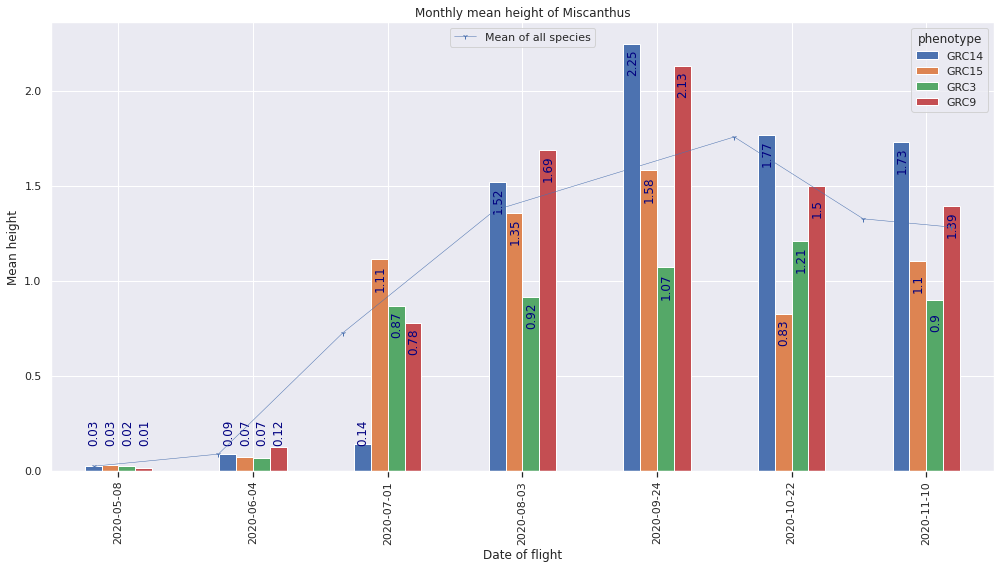

In [ ]:
plot_ts(groups['height'], 'height', vgap=(0.15,-0.15), hgap=0.02,size=12,rot=90, color = 'navy')

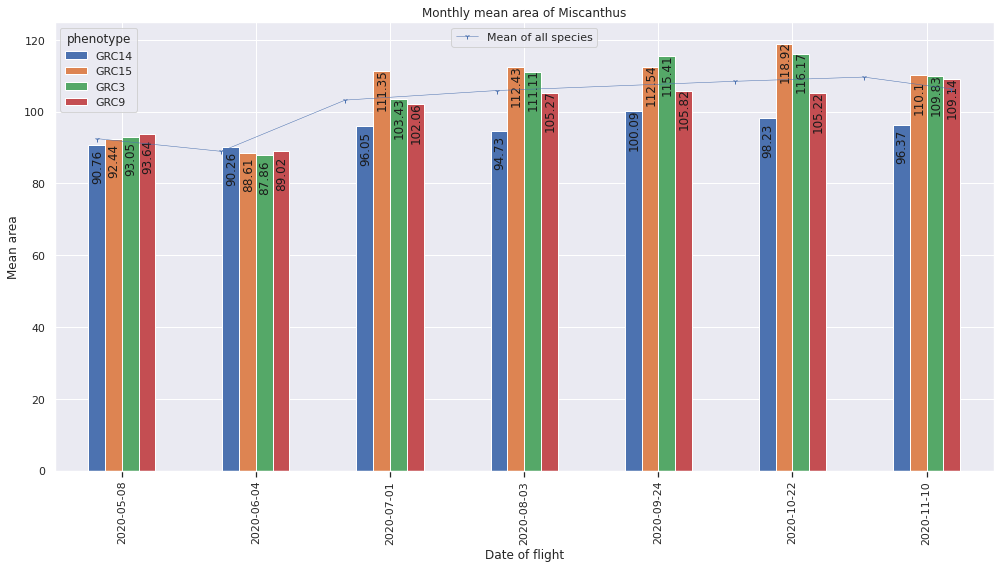

In [ ]:
plot_ts(groups['area'], 'area', vgap=(1,-10),hgap=0.02)

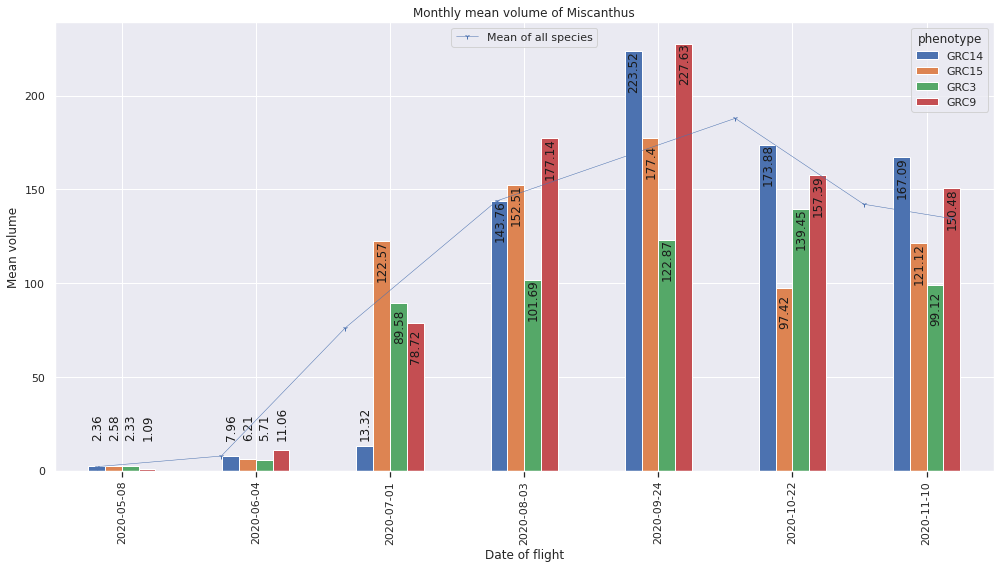

In [ ]:
plot_ts(groups['volume'], 'volume', vgap=(18,-20),hgap=0.02)


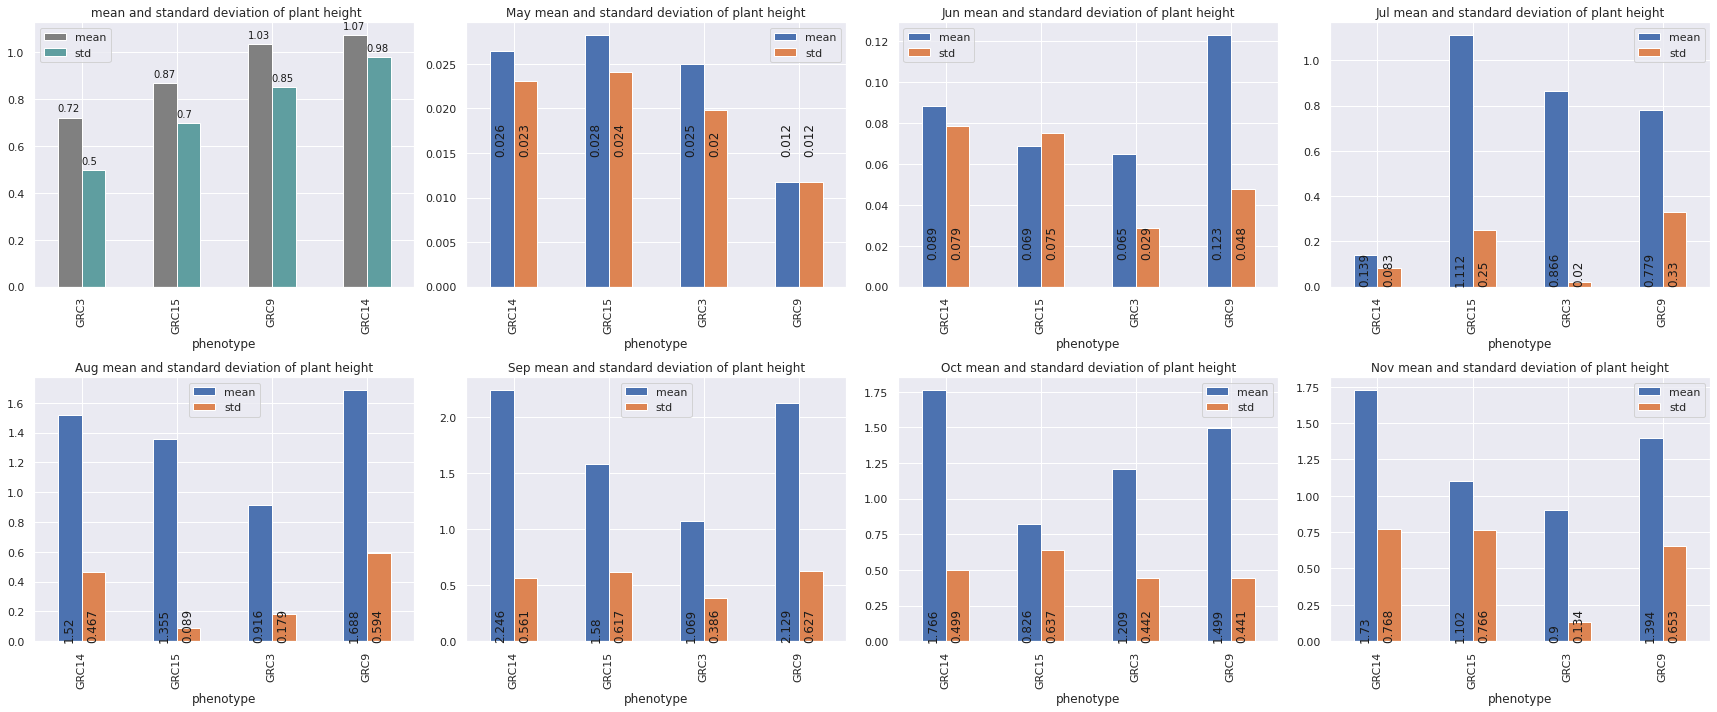

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(24,10))
axes=axes.ravel()

months = ['may','jun','jul','aug','sep','oct','nov']
bars = df.groupby('phenotype')['height'].agg([np.mean,np.std]).sort_values('mean').plot(kind='bar', label='height', ax=axes[0], 
                                        title = f' mean and standard deviation of plant height', color=['gray','cadetblue'])
annotate_barplot(bars,vgap=(0.01,0.025),hgap=0, rot= 0,size=10)

for ax,month in zip(axes[1:],months):  
  bars = df.where(df['month']==month).groupby('phenotype')['height'].agg([np.mean,np.std]).plot(kind='bar', label='height', ax=ax, 
                                        title = f'{month.capitalize()} mean and standard deviation of plant height')
  annotate_barplot(bars,vgap=(0.015,-1000),hgap=0.05, rot= 90, size=12,round=3)
 
plt.tight_layout()

In [ ]:
df.where(df['month']=='may').groupby('phenotype')['height'].agg([np.mean,np.std])

,mean,std
phenotype,,
GRC14,0.026417,0.023062
GRC15,0.028247,0.024067
GRC3,0.024948,0.019868
GRC9,0.011758,0.011768


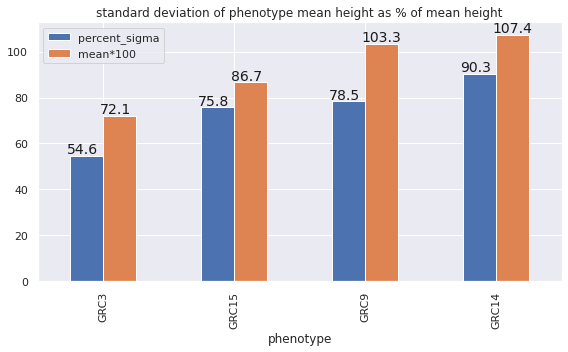

In [ ]:
agg = df.groupby('phenotype')['height'].agg([np.mean,np.std]).sort_values('mean')
agg['percent_sigma'] = 100-np.abs(agg['mean']-agg['std'])*100/agg['std']
agg['mean*100'] = agg['mean']*100

ax = agg[['percent_sigma','mean*100']].plot(kind='bar', figsize=(8,5), title =f'standard deviation of phenotype mean height as % of mean height')

annotate_barplot(ax, vgap=(0,1), hgap=-0.025, rot=0, round=1, size=14)
plt.tight_layout()


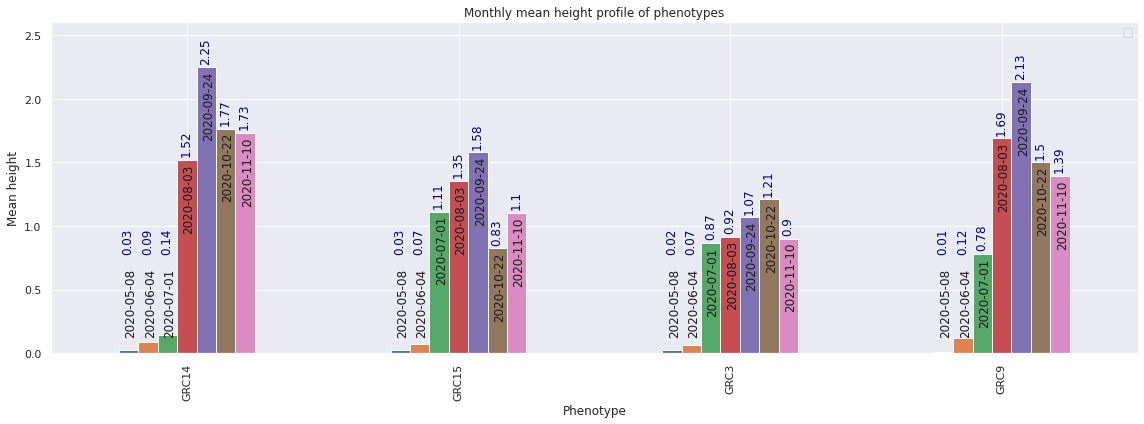

In [ ]:
ax = grouped['height'].unstack(level=1).plot(kind='bar', 
                                        figsize=(16,6), 
                                        title ='Monthly mean height profile of phenotypes', 
                                        ylabel='Mean height',
                                        xlabel= 'Phenotype', ylim=(0,2.6))

annotate_barplot_with_legend(ax,dates=False, vgap=(0.15,-0.55), hgap=0.02,size=12)  
annotate_barplot(ax, size=12,hgap=0.01,vgap=(0.8,0.05), color = 'navy', rot = 90) 
plt.tight_layout()


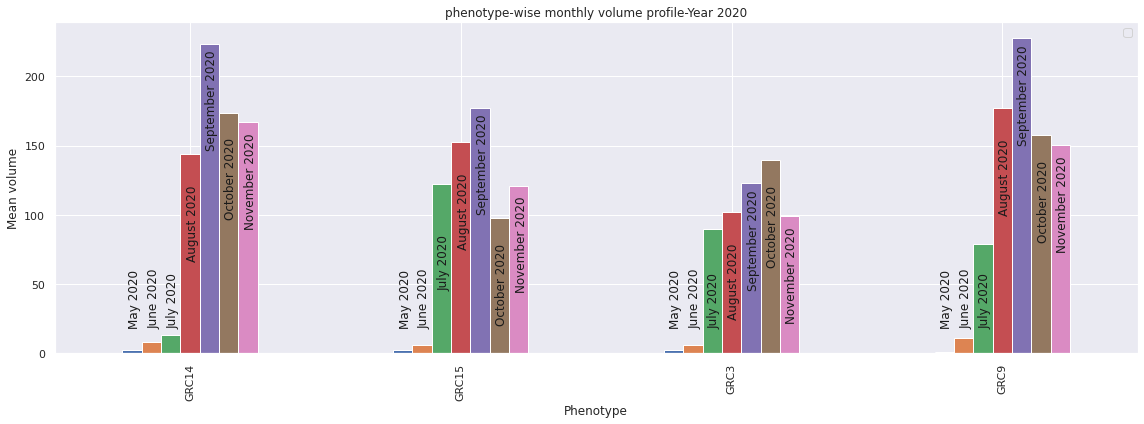

In [ ]:

ax = grouped['volume'].unstack(level=1).plot(kind='bar', 
                                        figsize=(16,6), 
                                        title ='phenotype-wise monthly volume profile-Year 2020', 
                                        ylabel='Mean volume',
                                        xlabel= 'Phenotype')
annotate_barplot_with_legend(ax,vgap=(20,-75),hgap=0.02, dates=True,size=12)
plt.tight_layout()

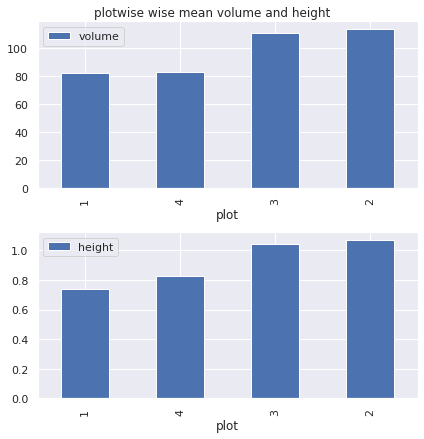

In [ ]:
fig, ax = plt.subplots(2,1, sharex=False, figsize=(6,6))
ax = ax.flatten()

plt.suptitle('plotwise wise mean volume and height', y=1.01)
vrowise = df.groupby('plot')[['volume']].mean().sort_values(['volume']).plot(kind='bar', ax=ax[0])
hrowise = df.groupby('plot')[['height']].mean().sort_values(['height']).plot(kind='bar', ax= ax[1])
plt.tight_layout()

(array([737546., 737577., 737607., 737638., 737669., 737699., 737730.]),
 <a list of 7 Text major ticklabel objects>)

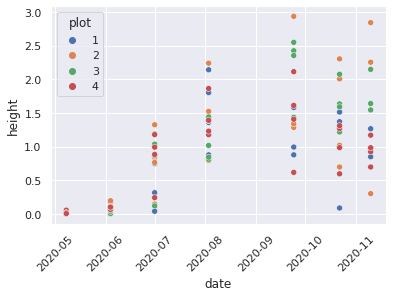

In [ ]:
#fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,13), sharey=True)

sns.scatterplot(data=df,x=df['date'],y=df['height'], hue =df['plot'])
#ax1.tick_params(axis='x', rotation=45)
plt.xticks(rotation=45)

#sns.scatterplot(data=df,x=df['date'],y=df['height'], hue =df['phenotype'], ax=ax2)
#ax2.tick_params(axis='x', rotation=45)

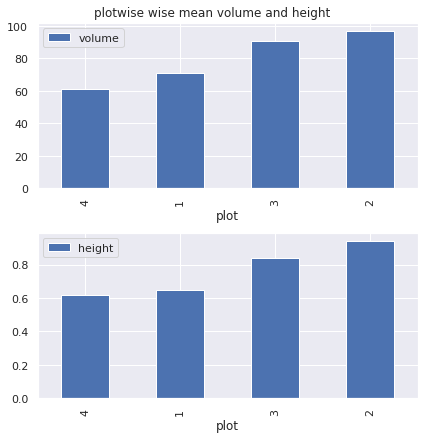

In [ ]:
fig, ax = plt.subplots(2,1, sharex=False, figsize=(6,6))
plt.suptitle('plotwise wise mean volume and height', y=1.01)
vrowise = df.groupby('plot')[['volume']].std().sort_values(['volume']).plot(kind='bar', ax=ax[0])
hrowise = df.groupby('plot')[['height']].std().sort_values(['height']).plot(kind='bar', ax= ax[1])

plt.tight_layout()

#Part 2 QGIS dataset analysis
In the following section we analyze the geojsons having values computed using zonal statistics plugin. And 

In [ ]:
nf = compile_jsons('qstats.geojson')

nf.columns      = nf.columns.map(lambda x: x.lower())
nf['plot']      = nf['plot'].astype('str')

nf.rename({'pt':'phenotype', }, axis ='columns', inplace=True)
nf['phenotype'] = 'GRC' + nf['phenotype'].astype('str')


flight_date     = {
                'may':'08-05-2020',
                'jun':'04-06-2020',
                'jul':'01-07-2020',
                'aug':'03-08-2020',
                'sep':'24-09-2020',
                'oct':'22-10-2020',
                'nov':'10-11-2020'
                }
flight_date     = {k:pd.to_datetime(v, format='%d-%m-%Y') for k,v in flight_date.items()}


nf['date']      = nf['month'].map(flight_date).dt.date
nf['date']      = pd.to_datetime(nf['date'], format='%Y-%m-%d')
nf['month']     = nf['date'].dt.month_name()

nf.head()

,length,area,volume,plot,phenotype,_count,_mean,_stdev,_min,_max,_range,height_mean,area_zc,volume_zc,varimean,ngrdimean,month,date
0,42.964553,122.780364,92.16,1,GRC15,254403.0,696.594596,0.696174,694.900024,697.869995,2.969971,1.695,122.887,208.293,-0.368179,-0.229941,July,2020-07-01
1,41.259379,109.497101,95.46,1,GRC3,226889.0,696.280676,0.480755,694.900024,697.140015,2.239990,1.381,109.585,151.337,-0.331609,-0.216990,July,2020-07-01
2,40.223949,106.348045,89.19,2,GRC3,220372.0,696.019549,0.551847,694.609985,697.049988,2.440002,1.410,106.433,150.071,-0.366451,-0.248599,July,2020-07-01
3,41.756410,111.280979,147.53,2,GRC15,230596.0,695.366234,0.728658,693.599976,696.520020,2.920044,1.766,111.370,196.679,-0.364138,-0.228187,July,2020-07-01
4,39.570874,101.077673,77.50,2,GRC9,209465.0,693.108293,0.625873,691.929993,694.159973,2.229980,1.178,101.159,119.165,-0.351641,-0.240845,July,2020-07-01


In [ ]:
weight = pd.read_excel('weights.xlsx')
weight.columns = weight.columns.map(lambda x : x.lower())
weight['strain']= weight['strain'].map(lambda x: x.replace(' ',''))
weight.rename({'strain':'phenotype'}, axis = 'columns', inplace =True)
weight.rename({'dm yield serial cut t/ha neu':'yield'}, axis ='columns', inplace =True)
weight['month'] = weight['date'].dt.month_name()



weight = weight.query("date< '2020-12-01'")
#unique dates in dataframe
dates = [ix for ix, grp in weight.groupby('date')]

weight.head(),weight.shape

(        date  cw plot id  location phenotype  yield month
 0 2020-05-05  19    G411  OLI 2 PS     GRC14   0.02   May
 1 2020-05-05  19    G421  OLI 2 PS     GRC14   0.04   May
 2 2020-05-05  19    G436  OLI 2 PS     GRC14   0.02   May
 3 2020-05-05  19    G456  OLI 2 PS     GRC14   0.03   May
 4 2020-05-19  21    G411  OLI 2 PS     GRC14   0.01   May, (240, 7))

In [ ]:
weight = weight.groupby(['month','plot id','phenotype'])['yield'].mean().reset_index()

In [ ]:
plot_mapper = {}
    
for i,j in zip(range(401,457,14),range(1,5)):
  plot_mapper.update({str(j):range(i,i+14)})

def map_plots(id, mapper = plot_mapper):
  #id = id[-3:]
  #id = int(id)
  
  for k,v in mapper.items():
    if id in v:
      return k

In [ ]:
weight['plot'] = weight['plot id'].map(lambda x : map_plots(int(x[-3:])))
weight.head()

,month,plot id,phenotype,yield,plot
0,August,G401,GRC9,8.590,1
1,August,G406,GRC15,10.945,1
2,August,G407,GRC3,10.700,1
3,August,G411,GRC14,4.940,1
4,August,G415,GRC3,14.305,2


In [ ]:
weight_dates = [dates[i] for i in [0,2,5,7,10,12,13]] #list of measurement dates nearest to and less than the flight date
print(f'flight date \t weight study date')
for k,v in zip(flight_date.values(),weight_dates):
  print(k.date(),'\t',v.date())

flight date 	 weight study date
2020-05-08 	 2020-05-05
2020-06-04 	 2020-06-02
2020-07-01 	 2020-07-14
2020-08-03 	 2020-08-11
2020-09-24 	 2020-09-22
2020-10-22 	 2020-10-20
2020-11-10 	 2020-11-05


In [ ]:
mapper ={i.month_name():i for i in weight_dates}
def date_filter(date,date_list = weight_dates):

  if date in date_list:
    return True
  else : 
    return False


def date_from_month(month,date_list=mapper):
  
  return date_list[month]
  


In [ ]:
weight['date'] = weight['month'].map(lambda x : mapper[x])
weight.head()

,month,plot id,phenotype,yield,plot,date
0,August,G401,GRC9,8.590,1,2020-08-11
1,August,G406,GRC15,10.945,1,2020-08-11
2,August,G407,GRC3,10.700,1,2020-08-11
3,August,G411,GRC14,4.940,1,2020-08-11
4,August,G415,GRC3,14.305,2,2020-08-11


In [ ]:
#weight = weight[weight['date'].map(lambda x : x in weight_dates)]
weight.shape

(112, 6)

In [ ]:
nf.shape

(110, 18)

In [ ]:
merged = pd.merge(weight,nf, on =['month','phenotype','plot'])
merged['height'] = merged['volume']/merged['area']
merged.rename({'height_mean':'height_zc'}, axis = 1, inplace =True)

merged = merged[['month', 'plot','phenotype','_count', '_stdev','_range',
                 'height','height_zc','area','area_zc','volume','volume_zc',
                 'yield','varimean','ngrdimean']]
                 

merged.rename({'_range':'max_height'}, axis =1, inplace =True)

print(merged.shape)
merged.head()

(110, 15)


,month,plot,phenotype,_count,_stdev,max_height,height,height_zc,area,area_zc,volume,volume_zc,yield,varimean,ngrdimean
0,August,1,GRC9,202206.0,0.661836,4.169983,1.803391,3.411,112.837396,112.928,203.49,385.197,8.590,0.442024,0.304643
1,August,1,GRC15,210884.0,0.789561,3.760010,1.360650,2.457,117.679093,117.774,160.12,289.371,10.945,0.422120,0.270953
2,August,1,GRC3,211281.0,0.362938,2.849976,0.879368,2.107,117.880167,117.975,103.66,248.573,10.700,0.433715,0.314817
3,August,1,GRC14,166887.0,0.667292,3.730042,2.141965,2.643,93.134094,93.209,199.49,246.351,4.940,0.387355,0.285468
4,August,2,GRC3,209278.0,0.443558,2.969971,0.793797,2.061,116.793124,116.887,92.71,240.904,14.305,0.429837,0.316568


In [ ]:
merged.describe()

,_count,_stdev,max_height,height,height_zc,area,area_zc,volume,volume_zc,yield,varimean,ngrdimean
count,1.100000e+02,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,3.109798e+05,0.501772,2.811545,0.921986,1.893218,102.078187,102.161464,97.443455,201.118055,9.180379,0.014991,0.007634
std,3.264882e+05,0.251056,1.325098,0.777685,1.124051,10.732337,10.741320,81.547963,125.917232,8.134998,0.227952,0.161080
min,2.813200e+04,0.134853,0.690002,0.001555,0.321000,84.402970,84.471000,0.150000,29.848000,0.005000,-0.402024,-0.275337
25%,1.561920e+05,0.257639,1.252487,0.093957,0.586250,93.186768,93.261750,8.995000,54.060250,1.987500,-0.121468,-0.093688
50%,2.110825e+05,0.529398,2.999908,0.905320,2.139000,100.410555,100.491000,99.460000,227.758000,7.742500,-0.017715,-0.012041
75%,2.729172e+05,0.671108,3.950012,1.390619,2.911750,109.484938,109.572750,152.747500,315.353250,14.022500,0.161788,0.113084
max,1.287336e+06,1.247625,4.750000,2.935399,3.599000,128.731898,128.835000,294.460000,395.879000,36.045000,0.442024,0.316568


In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

In [ ]:
ohe = OneHotEncoder(sparse = False)

ohe.fit(merged[['phenotype','plot']])

edf = pd.DataFrame(ohe.transform(merged[['phenotype','plot']]), 
                   columns=list(ohe.get_feature_names_out()), index = merged.index)
edf.columns = edf.columns.map(lambda x : x.replace('phenotype_',''))
edf.head()

,GRC14,GRC15,GRC3,GRC9,plot_1,plot_2,plot_3,plot_4
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
encoded = pd.merge(merged,edf, on =[merged.index,edf.index])
encoded.drop(['key_0','key_1'], axis =1, inplace =True)
encoded.columns = encoded.columns.map(lambda x : x.replace('mean',''))


encoded.head()

,month,plot,phenotype,_count,_stdev,max_height,height,height_zc,area,area_zc,volume,volume_zc,yield,vari,ngrdi,GRC14,GRC15,GRC3,GRC9,plot_1,plot_2,plot_3,plot_4
0,August,1,GRC9,202206.0,0.661836,4.169983,1.803391,3.411,112.837396,112.928,203.49,385.197,8.590,0.442024,0.304643,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,August,1,GRC15,210884.0,0.789561,3.760010,1.360650,2.457,117.679093,117.774,160.12,289.371,10.945,0.422120,0.270953,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,August,1,GRC3,211281.0,0.362938,2.849976,0.879368,2.107,117.880167,117.975,103.66,248.573,10.700,0.433715,0.314817,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,August,1,GRC14,166887.0,0.667292,3.730042,2.141965,2.643,93.134094,93.209,199.49,246.351,4.940,0.387355,0.285468,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,August,2,GRC3,209278.0,0.443558,2.969971,0.793797,2.061,116.793124,116.887,92.71,240.904,14.305,0.429837,0.316568,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


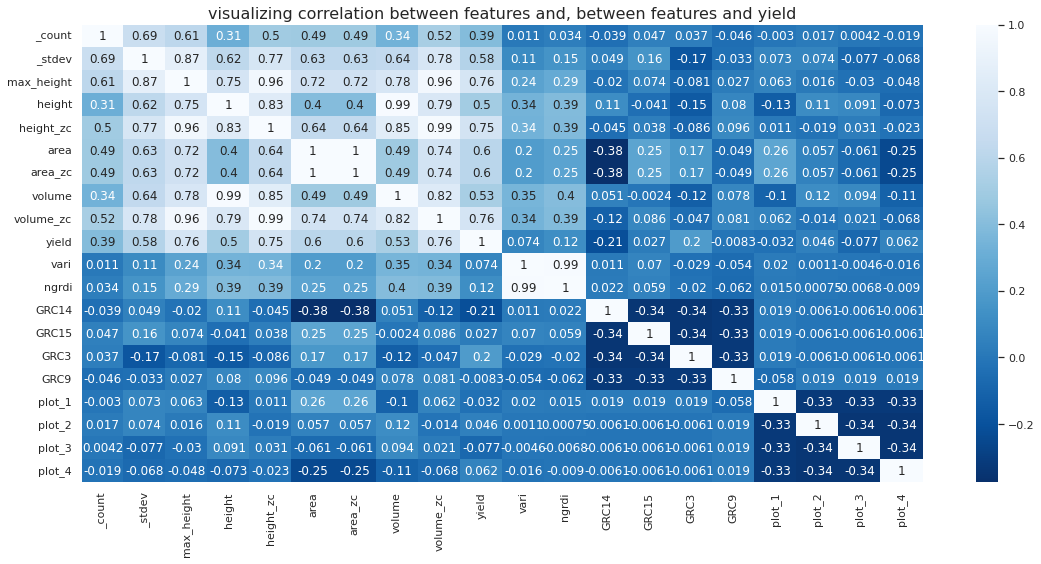

In [ ]:
plt.figure( figsize =(16,8))
plt.title('visualizing correlation between features and, between features and yield', size=16)
sns.heatmap(data = encoded.corr(), annot= True,  cmap='Blues_r')
plt.tight_layout()

In [ ]:

set1 = ['volume_zc','area_zc','max_height',
               'height_zc','vari','ngrdi',
               'GRC3','GRC9','GRC14','GRC15']

set2 = ['volume_zc','area_zc','max_height',
               'height_zc','vari','ngrdi']

set3 = ['area_zc','max_height','height_zc','vari','ngrdi']

set4 = ['height_zc','vari','ngrdi']
set4b = ['max_height','vari','ngrdi']

set5 = ['height_zc','ngrdi']
set5b = ['max_height','ngrdi']

set6 = ['max_height','height_zc']

set7 = ['height_zc']
set7b = ['max_height']


sets = [set1,set2,set3,set4,set4b,set5,set5b,set6,set7,set7b]

for i in sets:
  print(i)



#X_train,X_test, y_train,y_test = train_test_split(encoded.drop(['month','plot','phenotype','yield'], axis=1), encoded['yield'])

['volume_zc', 'area_zc', 'max_height', 'height_zc', 'vari', 'ngrdi', 'GRC3', 'GRC9', 'GRC14', 'GRC15']
['volume_zc', 'area_zc', 'max_height', 'height_zc', 'vari', 'ngrdi']
['area_zc', 'max_height', 'height_zc', 'vari', 'ngrdi']
['height_zc', 'vari', 'ngrdi']
['max_height', 'vari', 'ngrdi']
['height_zc', 'ngrdi']
['max_height', 'ngrdi']
['max_height', 'height_zc']
['height_zc']
['max_height']


In [ ]:
def make_models(alpha = 1):
  models = [LinearRegression(), Ridge(alpha=alpha), Lasso(alpha=alpha, max_iter=10000)]
  return models



def score_models(df,X,y,id,n=10, deg =4):
  X = X
  y = y
  

  scaler = MinMaxScaler()
  alphas = [0.001,0.01,0.1,0.25,0.5, 1, 2, 4, 8, 15, 25, 50,100]
  for i in range(n):

    for degree in range(1,deg):
      poly = PolynomialFeatures(degree = degree)
      X_poly = poly.fit_transform(X)
      X_train,X_test, y_train,y_test = train_test_split(X_poly,y)
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      
      for alpha in alphas: 
        models = make_models(alpha = alpha)
        
        for model in models:
          clf          = model
          clf.fit(X_train_scaled, y_train)
          score_train  = clf.score(X_train_scaled,y_train)
          score_test   = clf.score(X_test_scaled,y_test)
          df           = pd.concat([pd.DataFrame({'model':model,'alpha':alpha,'degree':degree,
                                                  'train_score':score_train,'test_score':score_test,'set':id},
                                            index =[0]),df],ignore_index = True)
  return df


In [ ]:
def test_models(top,dataset, n=10):
  
  nf = pd.DataFrame(columns=['model','degree','train_score','test_score','set']) 
  scaler = MinMaxScaler()

  for line in range(len(top)):
    model     = top.loc[line,'model']
    degree    = top.loc[line,'degree']
    set_id    = top.loc[line,'set']
    X         = dataset[sets[top.loc[line,'set']-1]]
    y         = dataset['yield']

    #feature transformation
    poly      = PolynomialFeatures(degree = degree)
    X_poly    = poly.fit_transform(X)

    for i in range(n):
      # feature splitting, scaling
      X_train,X_test, y_train,y_test = train_test_split(X_poly,y)
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)

      # model fitting 
      clf          = model
      clf.fit(X_train_scaled, y_train)

      score_train  = clf.score(X_train_scaled,y_train)
      score_test   = clf.score(X_test_scaled,y_test)
      nf           = pd.concat([pd.DataFrame({'model':model,'degree':degree,'train_score':score_train,
                                              'test_score':score_test,'set':set_id},
                                            index =[0]),nf],ignore_index = True)
  return nf



In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

scores = pd.DataFrame(columns=['model','alpha','degree','train_score','test_score','set'])

for ix, i in enumerate(sets):
  X,y = encoded[i], encoded['yield']
  scores = score_models(scores,X,y,ix+1,n=100)
  
scores.describe()


,alpha,train_score,test_score
count,117000.000000,117000.000000,117000.000000
mean,15.835462,0.475660,-30.891515
std,27.977334,0.414877,938.923595
min,0.001000,-25.149934,-74422.555283
25%,0.250000,0.400208,0.114391
50%,2.000000,0.581125,0.469533
75%,15.000000,0.635779,0.576306
max,100.000000,1.000000,0.904993


In [ ]:
import io
from google.colab import files
uploaded = files.upload()

Saving scores.xlsx to scores (1).xlsx


In [ ]:
scores = pd.read_excel('scores.xlsx')
scores.drop(['Unnamed: 0','clf'], axis =1, inplace=True)
scores.head()

,model,alpha,degree,train_score,test_score,set
0,"Lasso(alpha=100, max_iter=10000)",100.0,3,0.000000,-0.018598,10
1,Ridge(alpha=100),100.0,3,0.207062,0.150783,10
2,LinearRegression(),100.0,3,0.591423,0.500031,10
3,"Lasso(alpha=50, max_iter=10000)",50.0,3,0.000000,-0.018598,10
4,Ridge(alpha=50),50.0,3,0.321321,0.244900,10


In [ ]:

scores['clf'] = scores['model'].map(lambda x : str(x)[:5])
# sorting individual models on R-squared value 
top = scores.query("train_score > test_score and test_score > 0.5 and train_score > 0.6").sort_values('test_score', ascending =False).reset_index().drop('index', axis =1)

top.head()


,model,alpha,degree,train_score,test_score,set,clf
0,"Lasso(alpha=0.001, max_iter=10000)",0.001,3,0.892826,0.796805,1,Lasso
1,"Lasso(alpha=0.001, max_iter=10000)",0.001,2,0.793395,0.787242,1,Lasso
2,"Lasso(alpha=0.001, max_iter=10000)",0.001,2,0.790285,0.775239,1,Lasso
3,Ridge(alpha=0.01),0.010,3,0.858894,0.773788,1,Ridge
4,Ridge(alpha=0.01),0.010,2,0.777055,0.773383,1,Ridge


In [ ]:
# testing top five models to evaluate mean performance
from warnings import filterwarnings
filterwarnings('ignore')

models = [Lasso(alpha=0.001, max_iter=10000),
          Lasso(alpha=0.001, max_iter=10000),
          Lasso(alpha=0.001, max_iter=10000),
          Ridge(alpha=0.01),Ridge(alpha=0.01)]
top = top.iloc[:5,:]
top['model'] = models
n=100

perf_top = test_models(top.drop(['alpha','train_score','test_score','clf'], axis =1)[:5], encoded, n=n)
perf_top['clf'] = perf_top['model'].map(lambda x :str(x))
perf_top[::n]

,model,degree,train_score,test_score,set,clf
0,Ridge(alpha=0.01),2,0.829613,0.413781,1,Ridge(alpha=0.01)
100,Ridge(alpha=0.01),3,0.910827,0.021901,1,Ridge(alpha=0.01)
200,"Lasso(alpha=0.001, max_iter=10000)",2,0.829405,0.644550,1,"Lasso(alpha=0.001, max_iter=10000)"
300,"Lasso(alpha=0.001, max_iter=10000)",2,0.813600,0.711761,1,"Lasso(alpha=0.001, max_iter=10000)"
400,"Lasso(alpha=0.001, max_iter=10000)",3,0.931188,0.456598,1,"Lasso(alpha=0.001, max_iter=10000)"


In [ ]:
perf_top.groupby(['clf','degree','set'])[['train_score','test_score']].mean()

train_score  test_score
clf                                degree set                         
Lasso(alpha=0.001, max_iter=10000) 2      1       0.835371    0.372336
                                   3      1       0.920297   -0.052484
Ridge(alpha=0.01)                  2      1       0.817728    0.509598
                                   3      1       0.902081    0.085580

Aggregate performance of top models leaves a lot to desire, indicating that the high R-squared value was only by chance

In [ ]:
'''scores.to_excel('model_scores.xlsx')

from google.colab import files
files.download('model_scores.xlsx')'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Sorting models based on their mean R-squared value on test dataset
top_means = scores.query("clf != 'Linea'").groupby(['degree',
                                                   'alpha','set','clf'])[['train_score',
                                                                          'test_score']].mean().sort_values('test_score',
                                                                                                    ascending=False)[:25].reset_index()

top_means.head(5)

,degree,alpha,set,clf,train_score,test_score
0,2,1.0,1,Ridge,0.755280,0.642020
1,2,2.0,1,Ridge,0.741290,0.641236
2,2,0.1,1,Lasso,0.729706,0.638728
3,2,0.5,1,Ridge,0.766044,0.637700
4,2,4.0,1,Ridge,0.725101,0.637342


(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

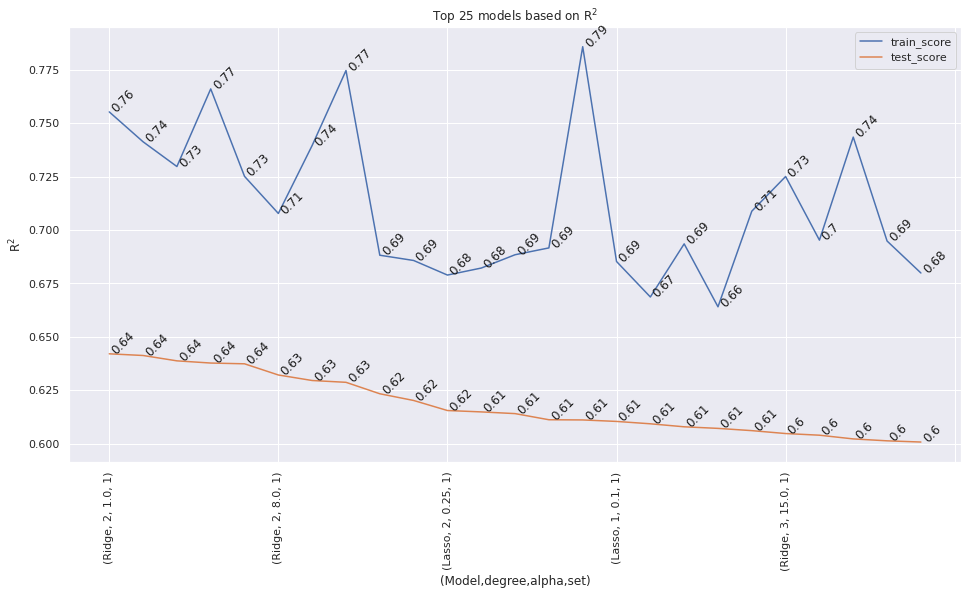

In [ ]:

ax = top_means.set_index(['clf','degree','alpha','set']).plot(figsize=(16,8), xlabel=f'(Model,degree,alpha,set)', ylabel='R$^2$')
ax.set_title('Top 25 models based on R$^2$')
annotate_line_plot(top_means.set_index(['clf','degree','alpha','set']),ax,rot=45)
plt.xticks(rotation=90)

In [ ]:
top_means.set_index(['clf','degree','alpha','set']).head()

train_score  test_score
clf   degree alpha set                         
Ridge 2      1.0   1       0.755280    0.642020
             2.0   1       0.741290    0.641236
Lasso 2      0.1   1       0.729706    0.638728
Ridge 2      0.5   1       0.766044    0.637700
             4.0   1       0.725101    0.637342

In [ ]:
def get_top_models(scores=scores,df = top_means, alpha = True):
  ''' pass alpha =False for linear models. Takes dataframes scores,df having complete model and individual model 
  parameters respectively. It returns merged df containing model for further sampling and testing '''

  subset = ['alpha','degree','set','clf']
  cols = ['model','degree','alpha','set','clf']

  if not alpha:
    subset.remove('alpha')  
    cols.remove('alpha')

  scores = scores.drop_duplicates(subset = subset)[cols]

  dropcols = ['train_score','test_score']
  return pd.merge(df.drop(dropcols, axis =1),scores, on = subset, sort=False)[cols]


In [ ]:
#Evaluating aggregate performance of better performing models on R-squared basis 

models = [Ridge(alpha=1),
          Ridge(alpha=2),
          Lasso(alpha=0.1, max_iter=100000),
          Ridge(alpha=0.5),Ridge(alpha=4)]
top = top_means.iloc[:5,:]

top['model'] = models
#temp = get_top_models(df=top_means)
n=100


perf = test_models(top,encoded, n=n)
perf['clf'] = perf['model'].map(lambda x :str(x))
perf.groupby(['clf','degree','set'])[['train_score','test_score']].mean().sort_values('test_score',ascending=False)

,,,train_score,test_score
clf,degree,set,,
Ridge(alpha=2),2,1,0.740817,0.650153
Ridge(alpha=1),2,1,0.756039,0.643427
Ridge(alpha=0.5),2,1,0.767449,0.631847
Ridge(alpha=4),2,1,0.727951,0.626143
"Lasso(alpha=0.1, max_iter=100000)",2,1,0.733361,0.614510


In [ ]:
top_linear = scores.query("clf =='Linea'").groupby(['degree',
                                                               'set','clf'])[['train_score',
                                                                        'test_score']].mean().sort_values('test_score',
                                                                                                  ascending =False)[:6].reset_index()
top_linear

,degree,set,clf,train_score,test_score
0,1,1,Linea,0.700569,0.587565
1,1,10,Linea,0.579112,0.558336
2,1,5,Linea,0.597569,0.557766
3,1,3,Linea,0.623861,0.557092
4,2,6,Linea,0.633630,0.550428
5,2,7,Linea,0.620671,0.548448


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text major ticklabel objects>)

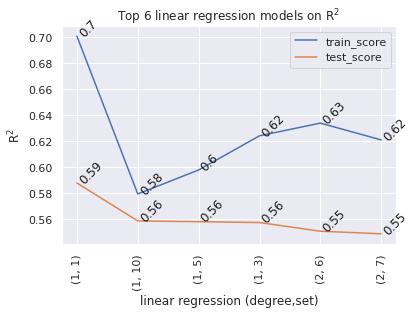

In [ ]:
ax = top_linear.drop('clf', axis=1).set_index(['degree','set']).plot(xlabel=f'linear regression (degree,set)', ylabel='R$^2$')
ax.set_title('Top 6 linear regression models on R$^2$')
annotate_line_plot(top_linear.drop('clf',axis=1).set_index(['degree','set']),ax,rot=45)
plt.xticks(rotation=90)

In [ ]:
temp = get_top_models(df = top_linear, alpha =False)

temp['model'] = LinearRegression()
perf_linear = test_models(temp,encoded, n=100)
perf_linear.groupby(['degree','set'])[['train_score','test_score']].mean().sort_values('test_score', ascending =False).reset_index()

,degree,set,train_score,test_score
0,1,1,0.694454,0.603019
1,1,10,0.578816,0.549457
2,2,6,0.634813,0.547113
3,1,3,0.626318,0.545076
4,1,5,0.601057,0.541510
5,2,7,0.625174,0.539493


In [ ]:
for s in sets:
  print(s)

['volume_zc', 'area_zc', 'max_height', 'height_zc', 'vari', 'ngrdi', 'GRC3', 'GRC9', 'GRC14', 'GRC15']
['volume_zc', 'area_zc', 'max_height', 'height_zc', 'vari', 'ngrdi']
['area_zc', 'max_height', 'height_zc', 'vari', 'ngrdi']
['height_zc', 'vari', 'ngrdi']
['max_height', 'vari', 'ngrdi']
['height_zc', 'ngrdi']
['max_height', 'ngrdi']
['max_height', 'height_zc']
['height_zc']
['max_height']


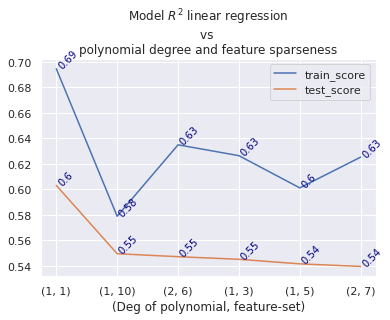

In [ ]:
temp = perf_linear.groupby(['degree','set'])[['train_score','test_score']].mean().sort_values('test_score', ascending =False)
ax = temp.plot(title = 'Model $R^2$ linear regression \nvs \npolynomial degree and feature sparseness', 
               xlabel='(Deg of polynomial, feature-set)')


  
annotate_line_plot(temp,ax,color ='navy',rot=45, size =10)  


In [ ]:

ls15 = perf_linear.query('degree==1 and set==5')['test_score'].reset_index().drop('index',axis=1)
ls15.rename({'test_score':'lm15'}, axis=1, inplace=True)
ls110 = perf_linear.query('degree==1 and set==10')['test_score'].reset_index().drop('index',axis=1)
ls110.rename({'test_score':'lm110'}, axis=1, inplace=True)

testdf = pd.concat([ls15,ls110], axis=1)
testdf.head()

,lm15,lm110
0,0.358701,0.651171
1,0.579436,0.460507
2,0.593012,0.546632
3,0.551681,0.413871
4,0.416427,0.307042


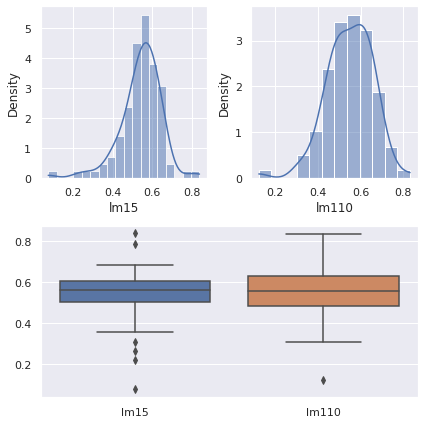

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(tight_layout =(True), figsize=(6,6))
gs = gridspec.GridSpec(2,2)
ax = fig.add_subplot(gs[1, :])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
sns.boxplot(data=testdf, ax=ax)
sns.histplot(testdf['lm15'], ax=ax1,stat='density',kde=True)
sns.histplot(testdf['lm110'], ax=ax2,stat='density',kde=True)

In [ ]:
n1  = n2 = 100
s1 = 0.093327 	
s2 = 0.101898
mu1 = 0.562396
mu2 = 0.560085
t   = 1.98
p1  = np.sqrt(((n1-1)*s1**2+(n2-1)*s2**2)/(n1+n2-2))
p2  = np.sqrt(2*1/100)
lcl =(mu1-mu2) - (t*p1*p1)
ucl =(mu1-mu2) + (t*p1*p1)
ts = (mu1-mu2)/(p1*p2)
(lcl,ucl),ts

((-0.016591200019670047, 0.02121320001966995), 0.16724816655166663)

In [ ]:
import scipy.stats.distributions as dist
import statsmodels.api as sm

sm.stats.zconfint(testdf['lm15'],testdf['lm110'])

(-0.03758558398333233, 0.021691354292841407)

In [ ]:
print(sm.stats.ztest(testdf.lm15,testdf.lm110))
print(sm.stats.ttest_ind(testdf.lm15,testdf.lm110))


(-0.5255352024126212, 0.5992111884171977)
(-0.5255352024126212, 0.5997992310885875, 198.0)


In [ ]:
testdf.describe()

,lm15,lm110
count,100.000000,100.000000
mean,0.562396,0.560085
std,0.093327,0.101898
min,0.262619,0.200544
25%,0.510692,0.503802
50%,0.560059,0.566307
75%,0.622999,0.621846
max,0.789062,0.770792


In [ ]:
filtered = scores.query("test_score>0").copy()
filtered['model'] =filtered['clf']

filtered.head()

,model,alpha,degree,train_score,test_score,set,clf
1,Ridge,100.0,3,0.207062,0.150783,10,Ridge
2,Linea,100.0,3,0.591423,0.500031,10,Linea
4,Ridge,50.0,3,0.321321,0.244900,10,Ridge
5,Linea,50.0,3,0.591423,0.500031,10,Linea
7,Ridge,25.0,3,0.436536,0.340759,10,Ridge


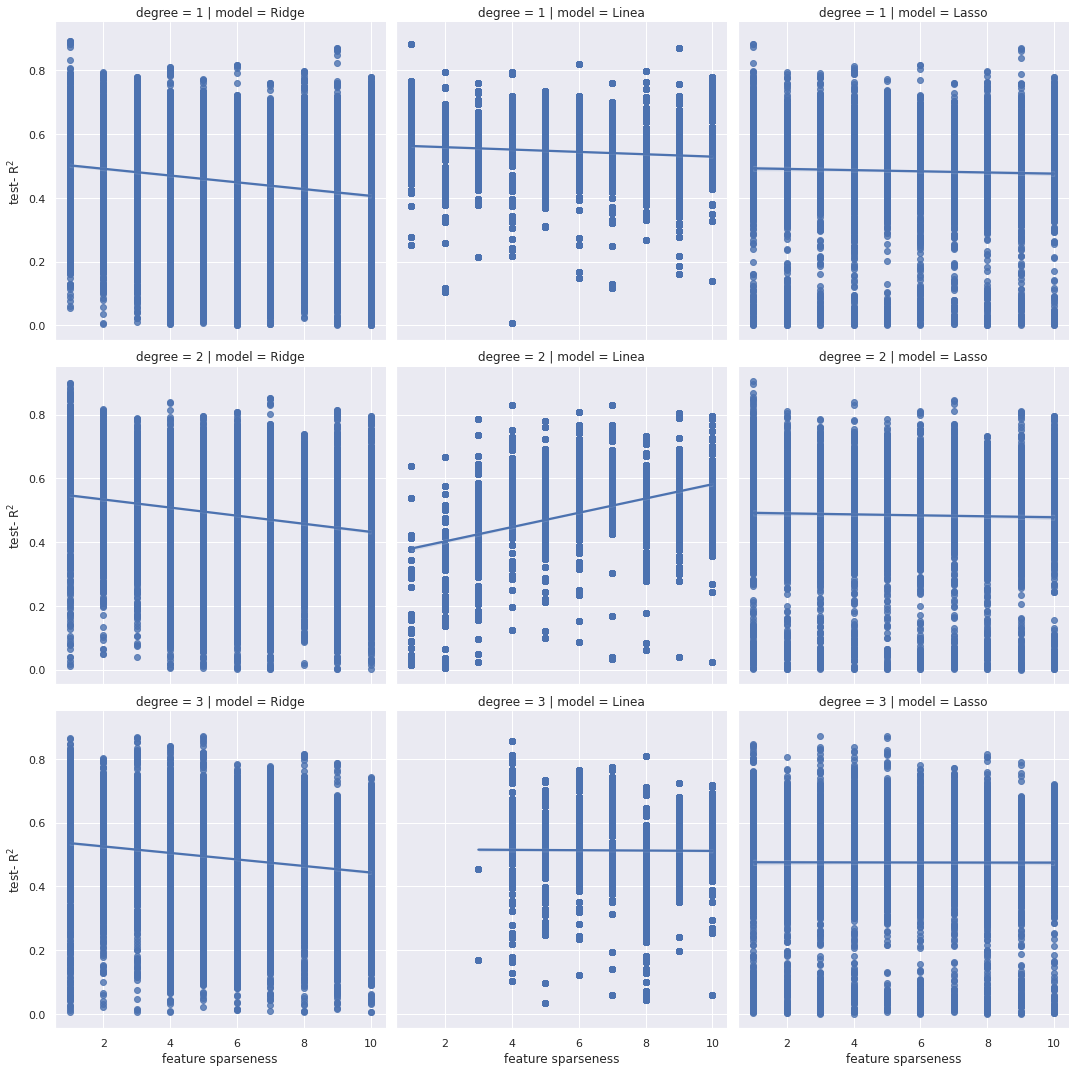

In [ ]:
ax = sns.lmplot(data =filtered, x='set',y='test_score',col='model', row = 'degree')
ax.set_xlabels('feature sparseness')
ax.set_ylabels('test- R$^2$')

In [ ]:
ax = sns.lmplot(data =filtered, x='set',y='test_score',col='model', row = 'degree',order=2)
ax.set_xlabels('feature sparseness')
ax.set_ylabels('test- R$^2$')

Text(0.5, 1.02, 'Visualizing linear model fit to mean of the test scores across feature sets')

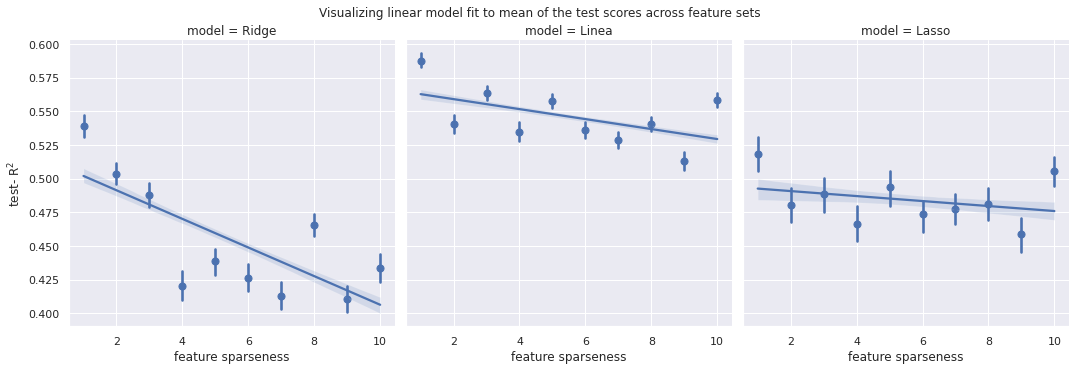

In [ ]:
ax = sns.lmplot(data =filtered[filtered['degree']==1], x='set',y='test_score',col='model', x_estimator=np.mean)
ax.set_xlabels('feature sparseness')
ax.set_ylabels('test- R$^2$')
ax.fig.suptitle('Visualizing linear model fit to mean of the test scores across feature sets',y=1.02)

Text(0.5, 1.01, 'Fitting 2$^{nd}$ order curve to mean of the test scores across feature sets')

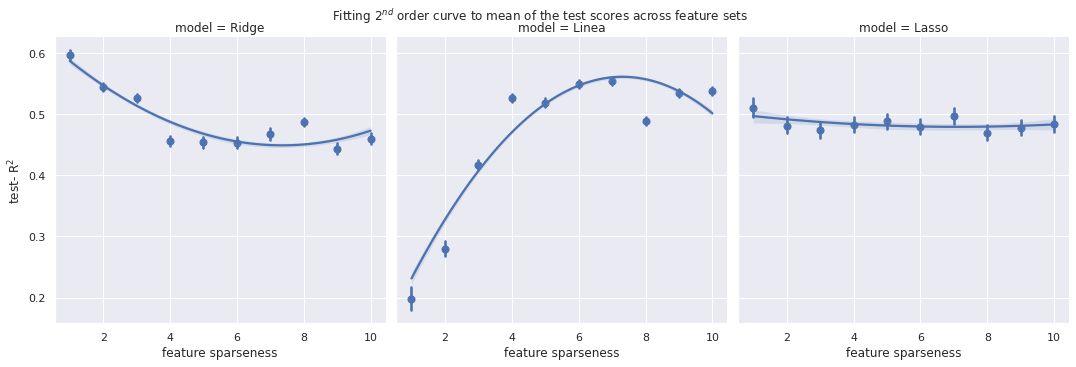

In [ ]:
ax = sns.lmplot(data =filtered[filtered['degree']==2], x='set',y='test_score',col='model', x_estimator=np.mean, order=2)
ax.set_xlabels('feature sparseness')
ax.set_ylabels('test- R$^2$')
ax.fig.suptitle('Fitting 2$^{nd}$ order curve to mean of the test scores across feature sets',y=1.01)

Text(0.5, 1.01, 'Fitting 3$^{rd}$ order curve to mean of the test scores across feature sets')

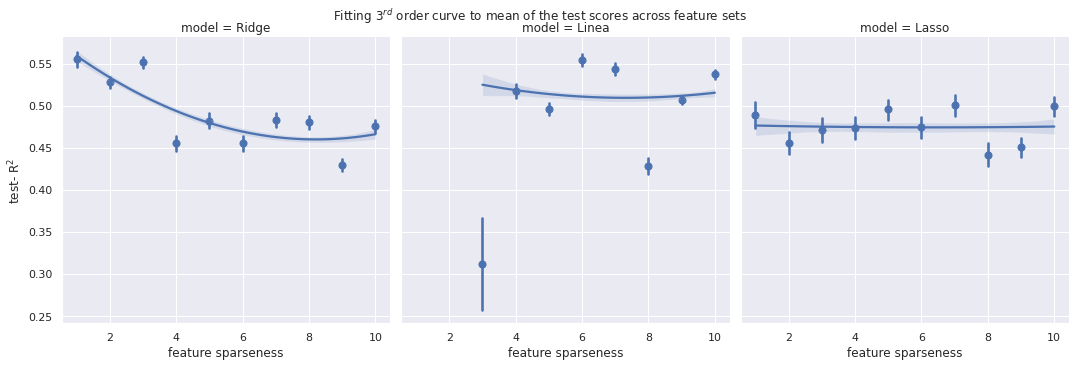

In [ ]:
ax = sns.lmplot(data =filtered[filtered['degree']==3], x='set',y='test_score',col='model', x_estimator=np.mean, order=2)
ax.set_xlabels('feature sparseness')
ax.set_ylabels('test- R$^2$')
ax.fig.suptitle('Fitting 3$^{rd}$ order curve to mean of the test scores across feature sets',y=1.01)

Text(0, 0.5, 'test- R$^2$')

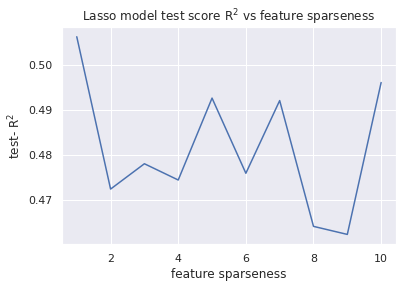

In [ ]:
lasso = filtered.query("clf=='Lasso'")
ax = lasso.groupby('set')['test_score'].mean().plot(title='Lasso model test score R$^2$ vs feature sparseness')
ax.set_xlabel('feature sparseness')
ax.set_ylabel('test- R$^2$')

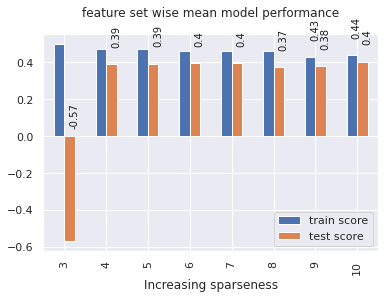

In [ ]:
ax = scores.drop('model',
                 axis =1).groupby('set')[['train_score',
                                                   'test_score']].mean().drop([1,2]).plot(kind ='bar',
                                                                                            title ='feature set wise mean model performance')

ax.set_xlabel('Increasing sparseness')
annotate_barplot(ax, hgap =0.12, vgap=(0.05,0.1), size =10)
ax.title.set_position([0.5,1.05])
plt.legend(['train score', 'test score'])


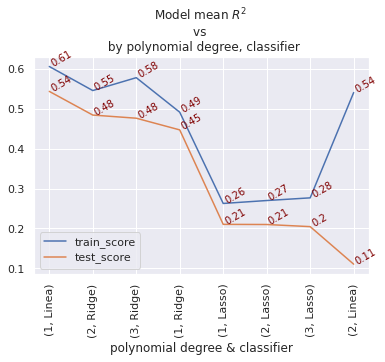

In [ ]:
temp = scores.groupby(['degree','clf'])[['train_score','test_score']].mean().query("test_score>0").sort_values('test_score', ascending =False)
ax = temp.plot(title ='Model mean $R^2$ \nvs \n by polynomial degree, classifier')
plt.xticks(rotation =90)
ax.set_xlabel('polynomial degree & classifier')
annotate_line_plot(temp,ax,size=10, color='maroon', rot=30)

In [ ]:
ax = scores.groupby('set')[['train_score',
                            'test_score']].mean().query("test_score>0").sort_values().plot(kind='bar', title ='Model sparseness vs train and test $R^2$')
ax.set_xlabel('feature sparseness')
annotate_barplot_with_legend(ax, size=10, color='k', hgap=0.04, vgap=(0.1,-0.27))
annotate_barplot(ax, size=10, hgap=0.04,vgap=(0.3,-0.1),color='k')




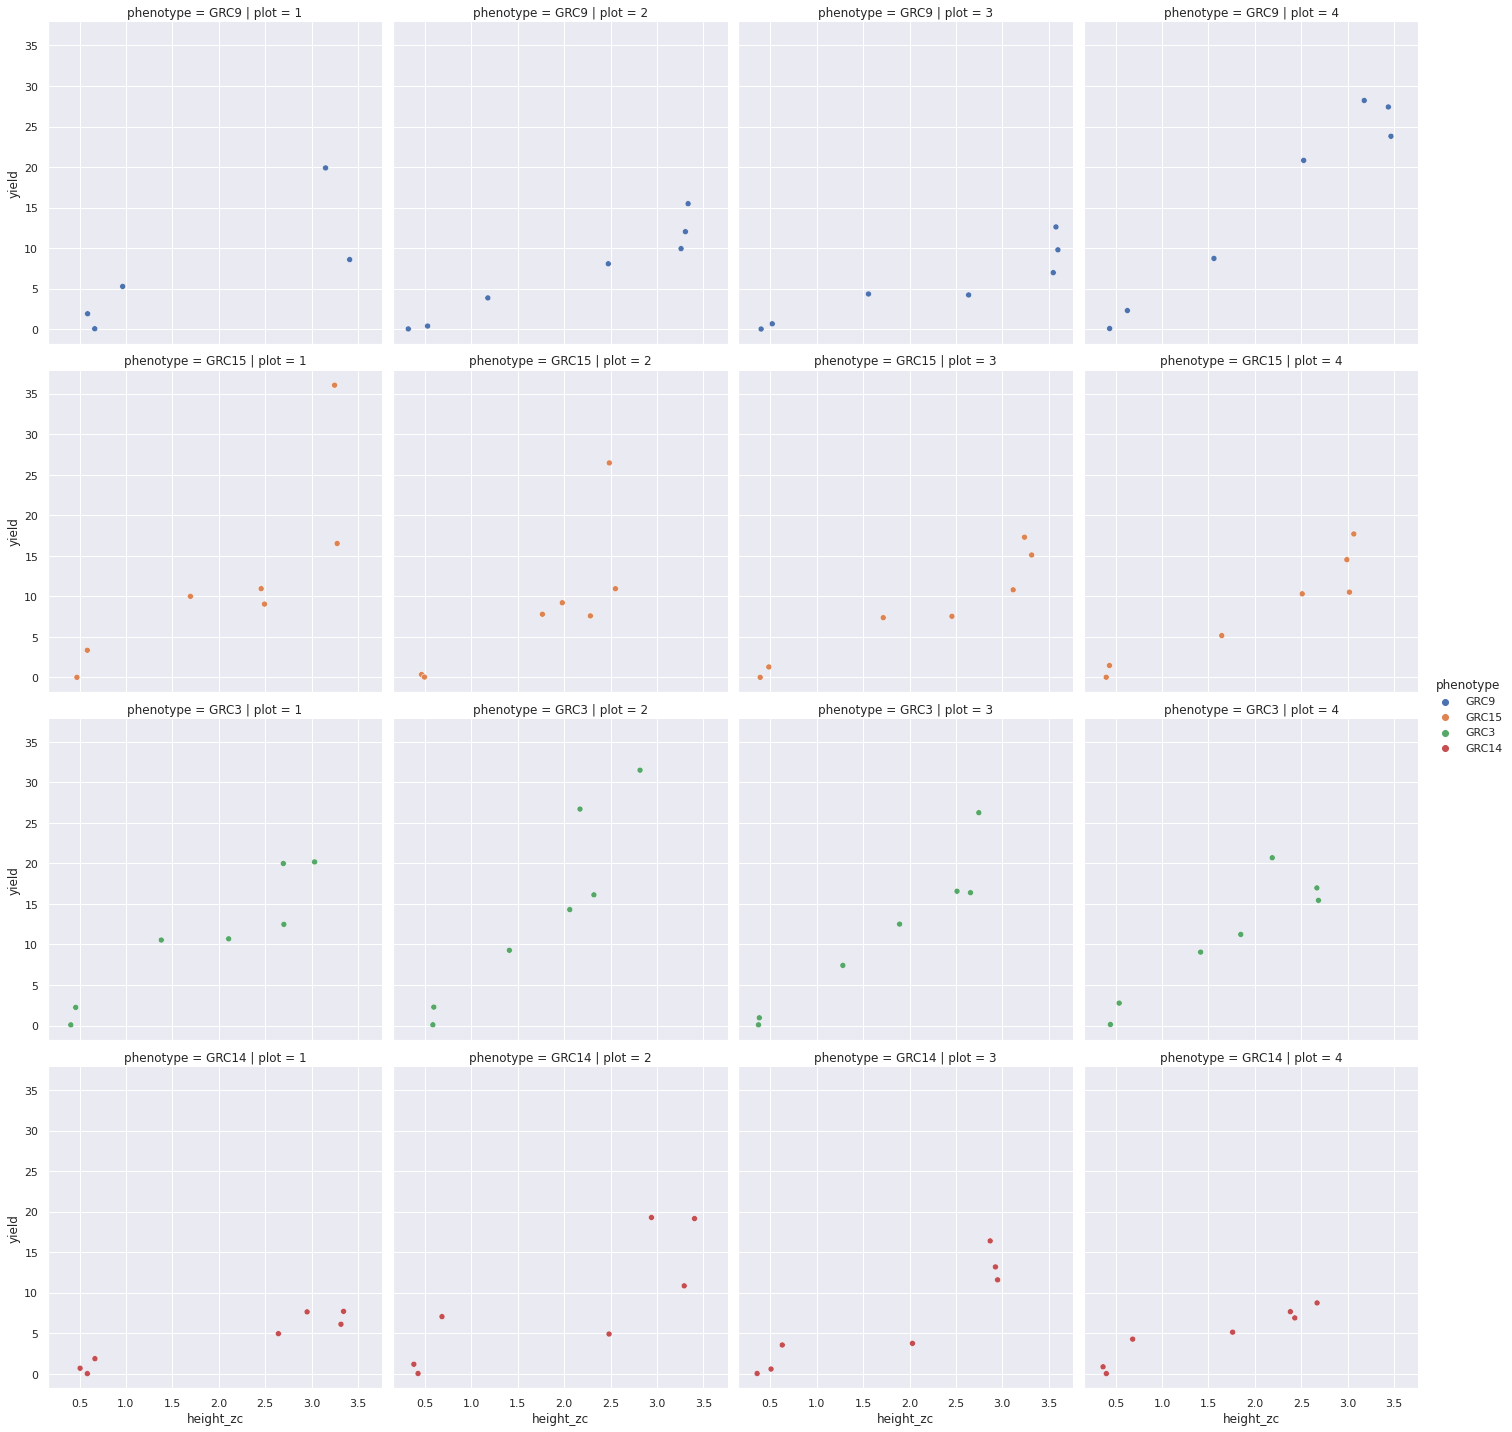

In [ ]:
sns.relplot( data =encoded, x='height_zc', y = 'yield', hue ='phenotype', col ='plot',row='phenotype')

In [ ]:
encoded.head()

,month,plot,phenotype,_count,_stdev,max_height,height,height_zc,area,area_zc,volume,volume_zc,yield,vari,ngrdi,GRC14,GRC15,GRC3,GRC9,plot_1,plot_2,plot_3,plot_4
0,August,1,GRC9,202206.0,0.661836,4.169983,1.803391,3.411,112.837396,112.928,203.49,385.197,8.590,0.442024,0.304643,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,August,1,GRC15,210884.0,0.789561,3.760010,1.360650,2.457,117.679093,117.774,160.12,289.371,10.945,0.422120,0.270953,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,August,1,GRC3,211281.0,0.362938,2.849976,0.879368,2.107,117.880167,117.975,103.66,248.573,10.700,0.433715,0.314817,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,August,1,GRC14,166887.0,0.667292,3.730042,2.141965,2.643,93.134094,93.209,199.49,246.351,4.940,0.387355,0.285468,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,August,2,GRC3,209278.0,0.443558,2.969971,0.793797,2.061,116.793124,116.887,92.71,240.904,14.305,0.429837,0.316568,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


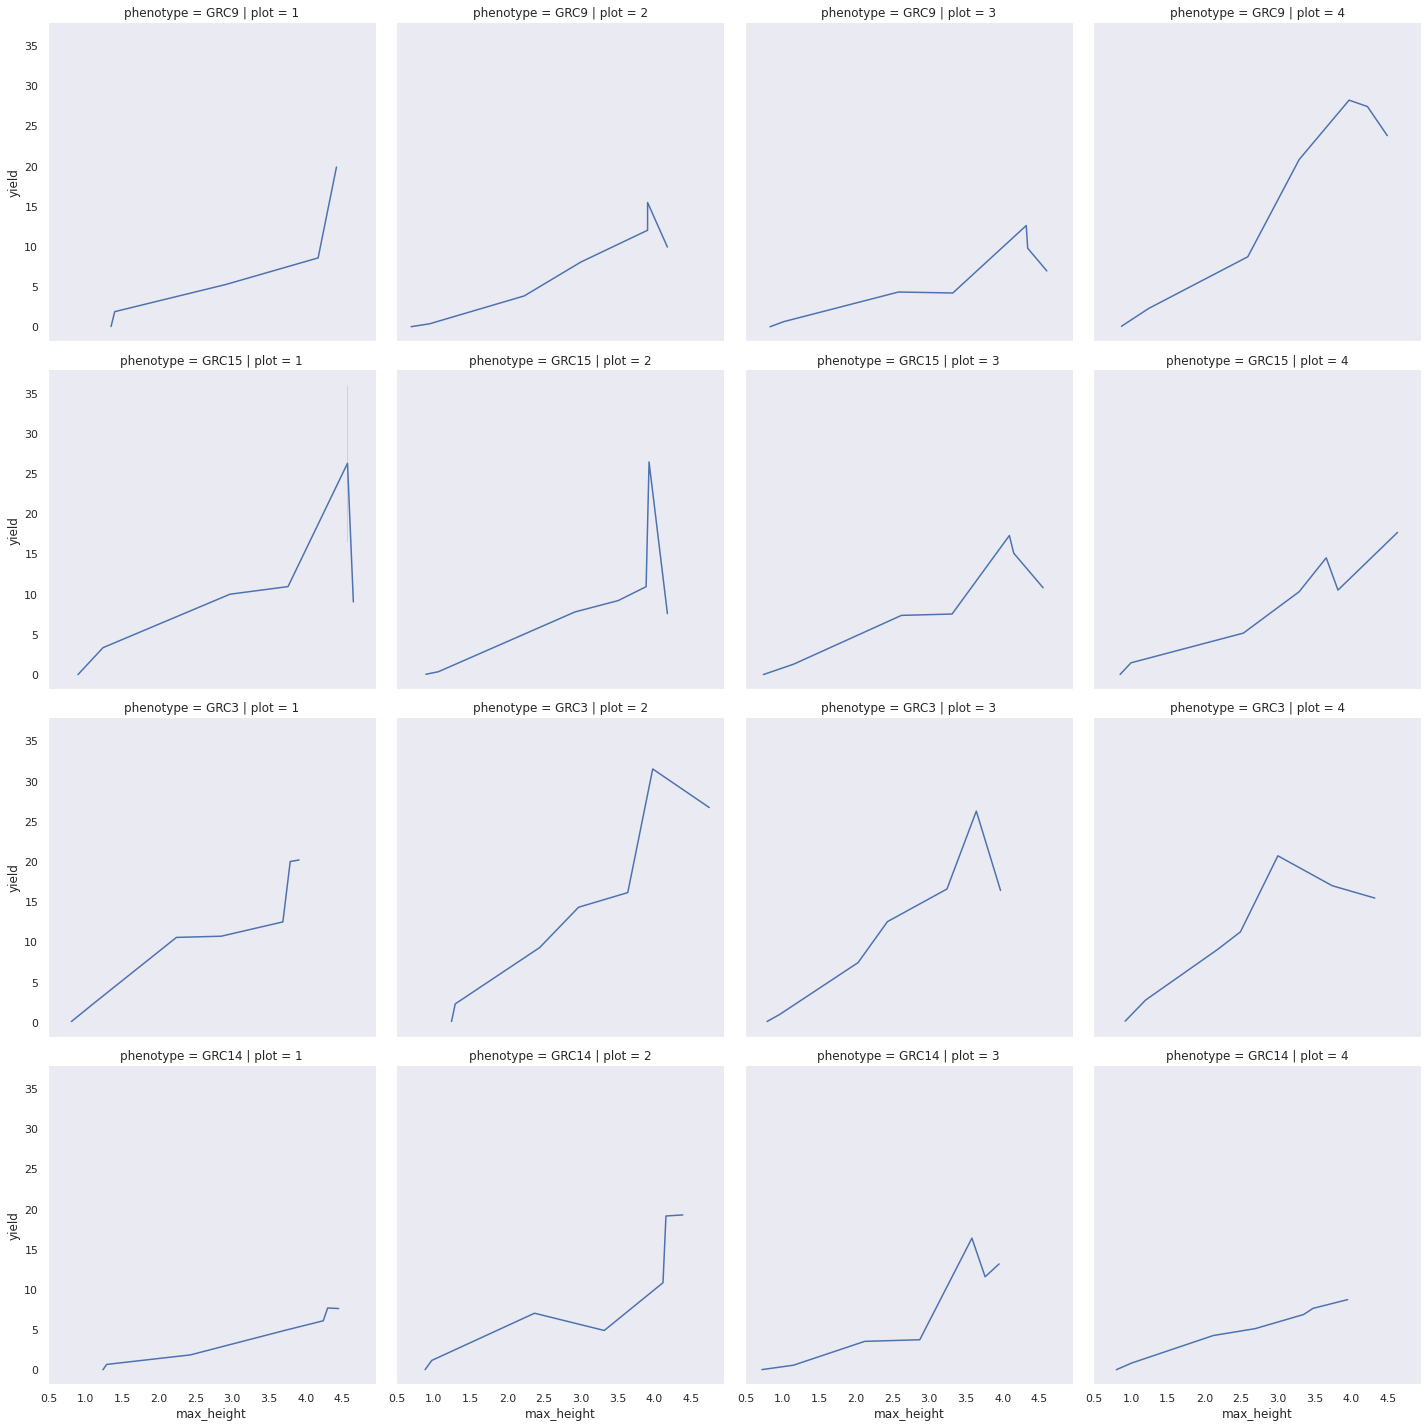

In [ ]:
sns.set_style('dark')
sns.relplot( data =encoded, x='max_height', y = 'yield', kind ='line', col ='plot',row='phenotype')

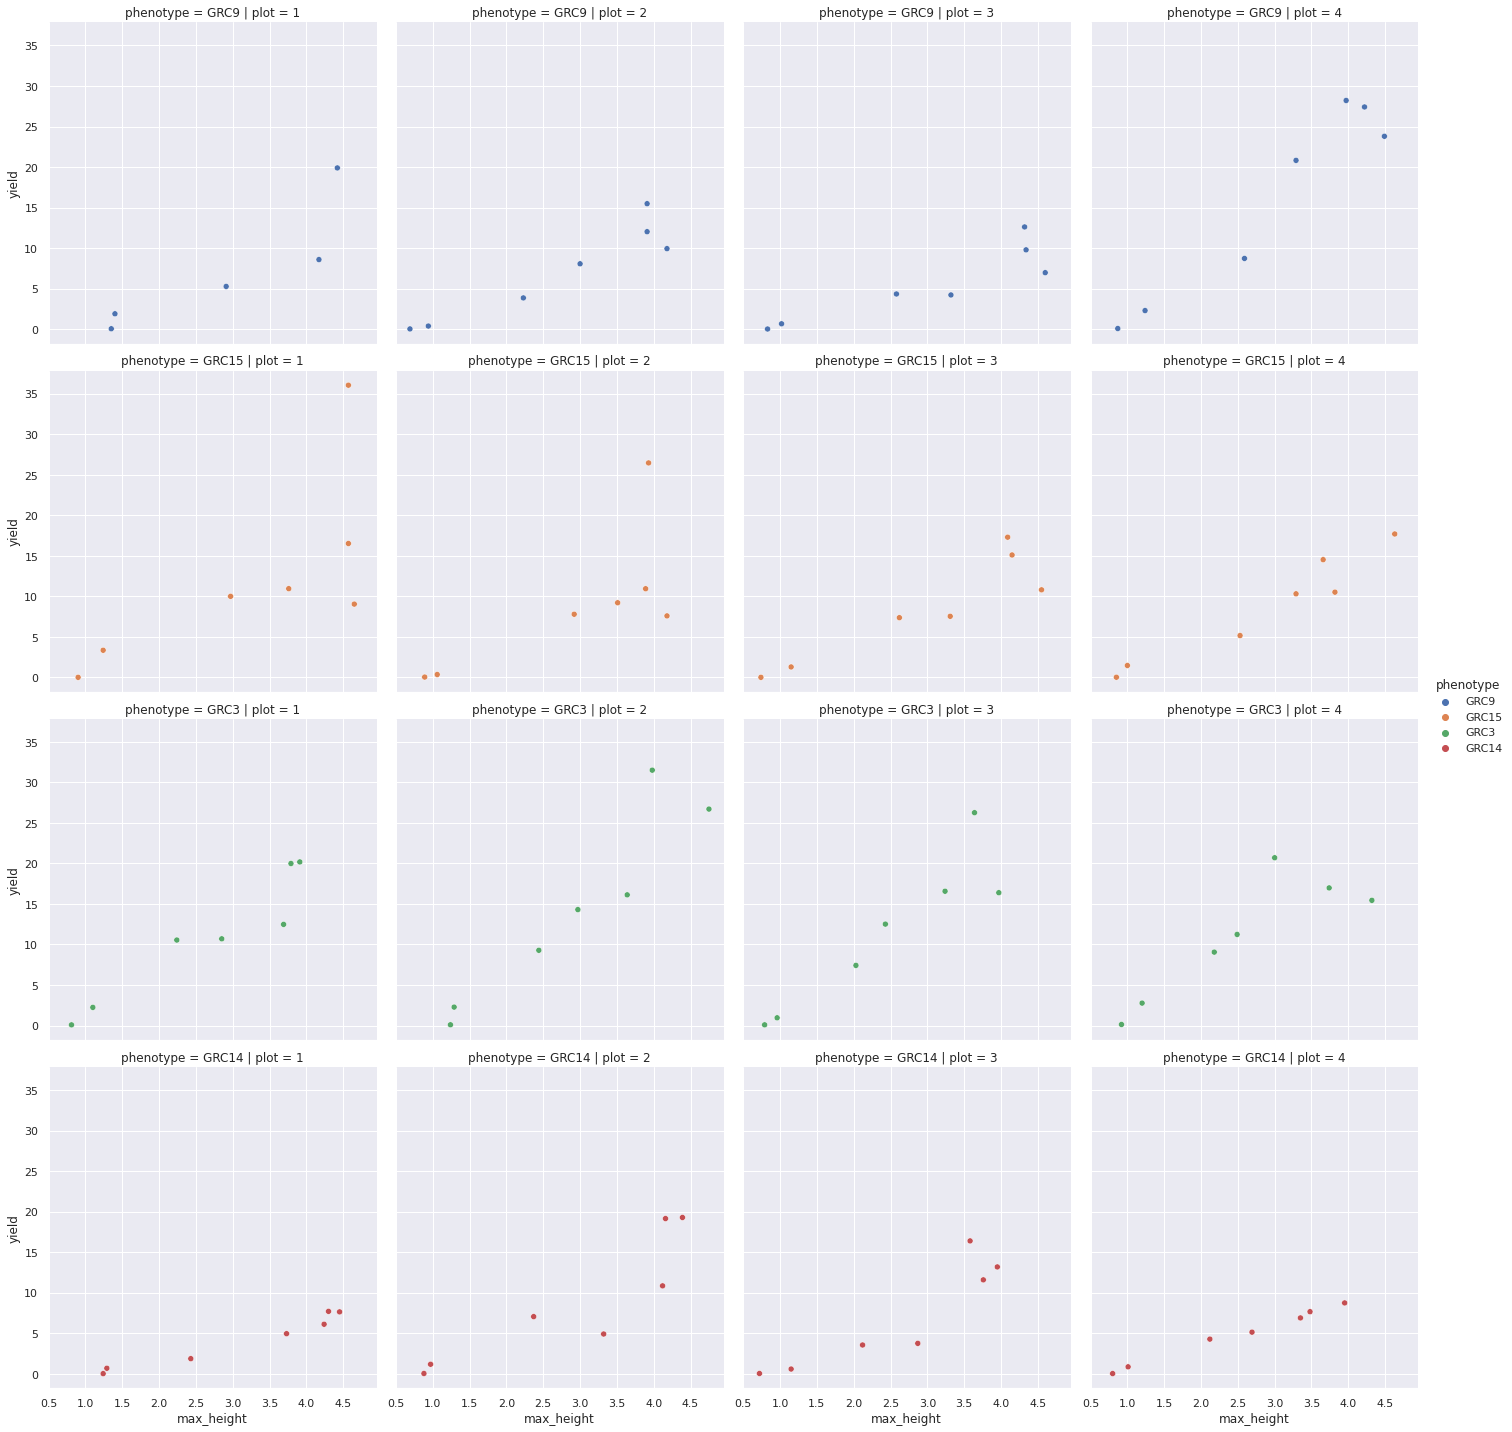

In [ ]:
sns.relplot( data =encoded, x='max_height', y = 'yield', hue ='phenotype', col ='plot',row='phenotype')

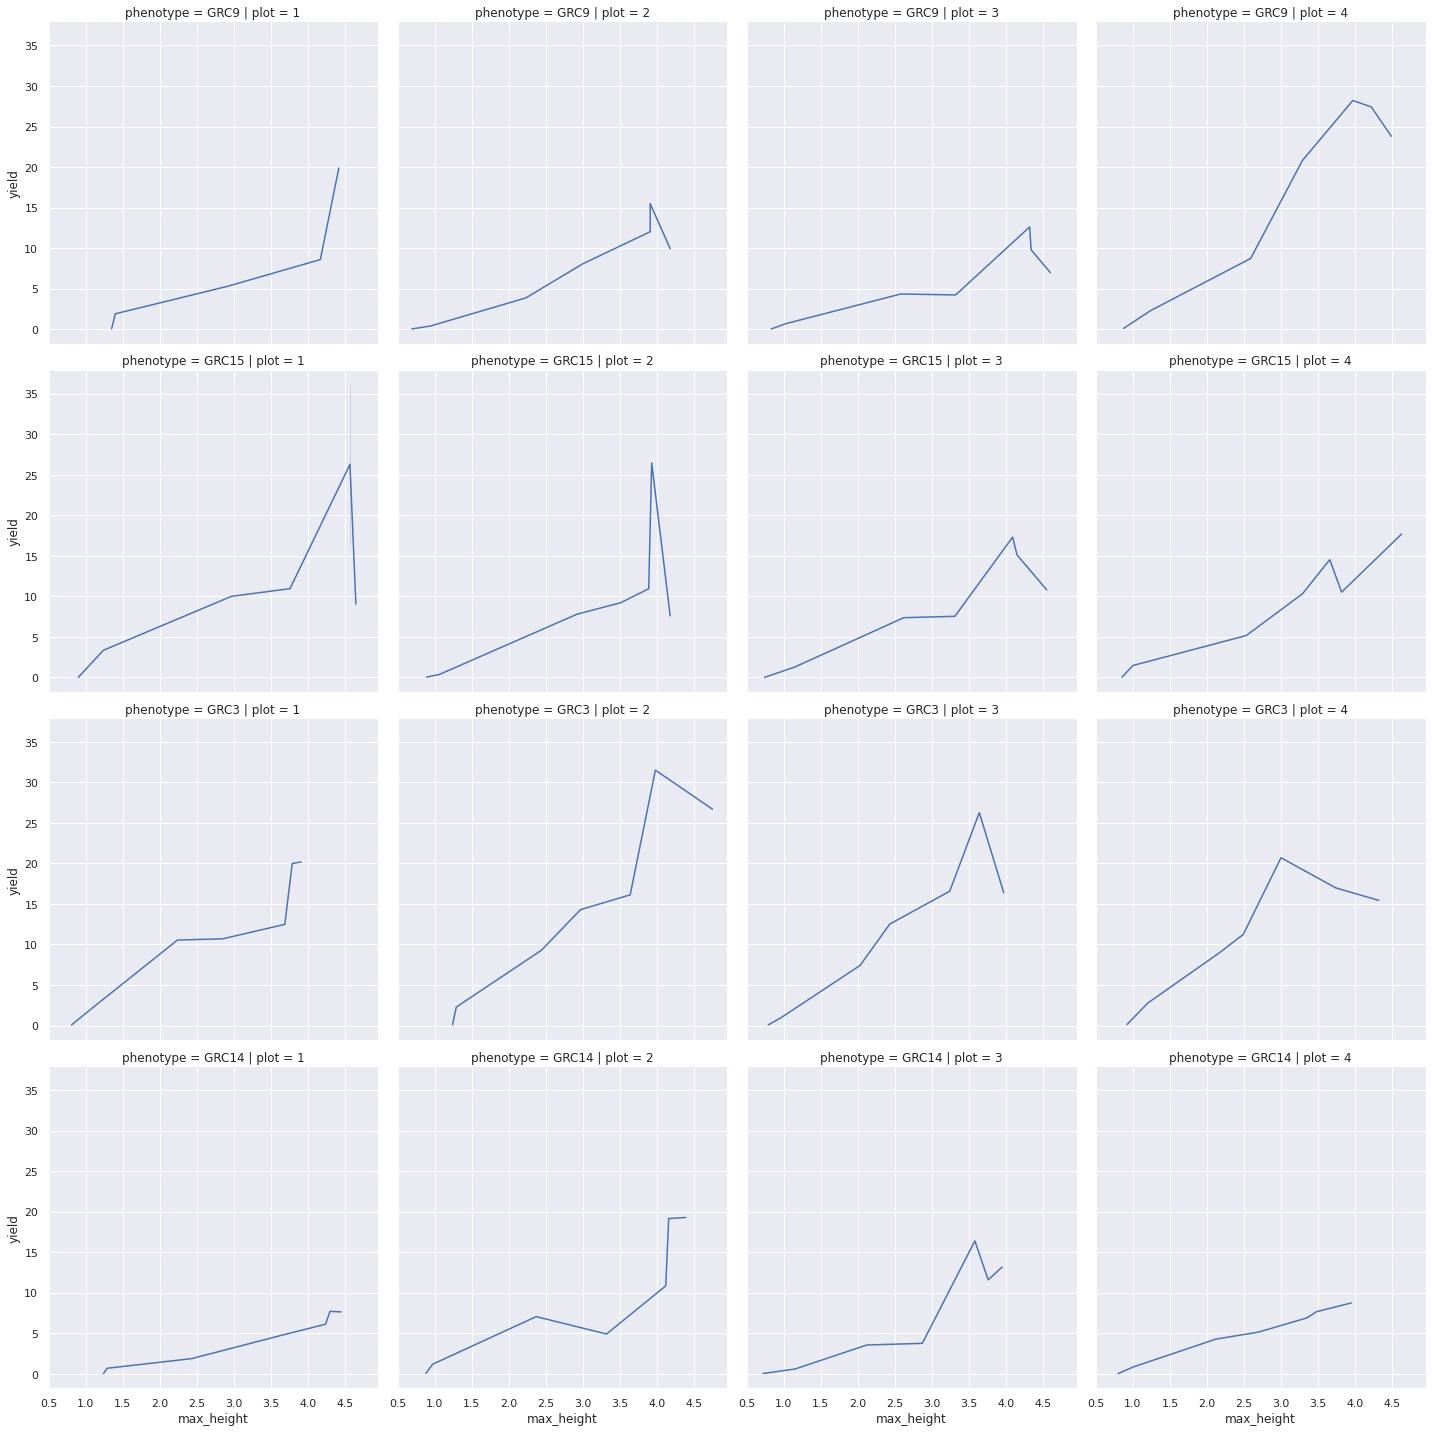

In [ ]:
sns.relplot( data =encoded, x='max_height', y = 'yield', kind ='line', col ='plot',row='phenotype')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


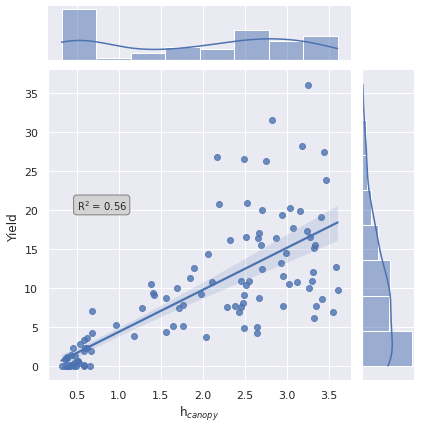

In [ ]:


x = encoded['height_zc']
x1 = sm.add_constant(x)

y = encoded['yield']


model = sm.OLS(y,x1)
results = model.fit()
r2 = results.rsquared

 

g = sns.jointplot( data =encoded, x='height_zc', y = 'yield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (0.5,20), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})

g.set_axis_labels(xlabel='h$_{canopy}$',ylabel='Yield')

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     135.1
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           9.63e-21
Time:                        17:49:36   Log-Likelihood:                -341.54
No. Observations:                 110   AIC:                             687.1
Df Residuals:                     108   BIC:                             692.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0335      1.021     -1.012      0.314      -3.057       0.990
height_zc      5.3950      0.464     11.622      0.000       4.475       6.315
==============================================================================
Omnibus:                       26.456   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.384
Skew:                           1.058   Prob(JB):                     2.30e-10
Kurtosis:                       5.282   Cond. No.                         5.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

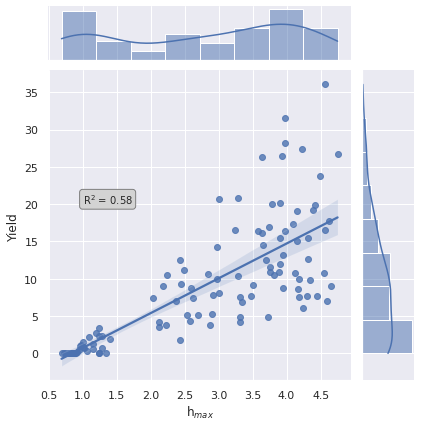

In [ ]:


x = encoded['max_height']
x1 = sm.add_constant(x)

y = encoded['yield']


model = sm.OLS(y,x1)
results = model.fit()
r2 = results.rsquared



g = sns.jointplot( data =encoded, x='max_height', y = 'yield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (1,20), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})
g.set_axis_labels(xlabel='h$_{max}$', ylabel='Yield')


#Loading infield heights measurement data and merging with drone estimate measurements

In [ ]:
heights = pd.read_excel('heights.xlsx').dropna()


heights.columns = heights.columns.map(lambda x : x.lower())
heights['stock: strain']= heights['stock: strain'].map(lambda x: x.replace(' ',''))

#renaming few columns
heights.rename({'stock: strain':'phenotype'}, axis = 'columns', inplace =True)
heights.rename({'observed date':'date'}, axis = 'columns', inplace =True)
heights.rename({'stock id':'plot id'}, axis = 'columns', inplace =True)
heights.rename({'value':'height'}, axis = 'columns', inplace =True)

heights['month'] = heights['date'].dt.month_name()
heights = heights[heights['measurement of']=='ShootHeight_cm']
heights.drop(['measurement of','stock: location name', 'pseudo rep'], axis =1, inplace =True)

heights.head(),heights.shape



(        date  height plot id phenotype month
 0 2020-05-05      11    G436     GRC14   May
 1 2020-05-05      29    G411     GRC14   May
 2 2020-05-05       6    G421     GRC14   May
 3 2020-05-05      22    G456     GRC14   May
 4 2020-06-02      56    G411     GRC14  June, (480, 5))

In [ ]:
heights = heights.groupby(['month','plot id','phenotype'])['height'].mean().reset_index()

height_dates = {
                'May'       :'05-05-2020',
                'June'      :'02-06-2020',
                'July'      :'14-07-2020',
                'August'    :'11-08-2020',
                'September' :'22-09-2020',
                'October'   :'13-10-2020',
                'November'  :'10-11-2020'
                }


heights['date'] = heights['month'].map(lambda x: height_dates[x])
heights['date'] = pd.to_datetime(heights['date'], format='%d-%m-%Y')

heights['plot'] = heights['plot id'].map(lambda x : map_plots(int(x[-3:])))
heights = heights.sort_values('date').reset_index().drop('index', axis =1)
heights['height'] = heights['height']/100
heights.head()

,month,plot id,phenotype,height,date,plot
0,May,G401,GRC9,0.346,2020-05-05,1
1,May,G406,GRC15,0.082,2020-05-05,1
2,May,G411,GRC14,0.276,2020-05-05,1
3,May,G415,GRC3,0.356,2020-05-05,2
4,May,G421,GRC14,0.118,2020-05-05,2


In [ ]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['month'] = df['date'].dt.month_name()

hh = pd.merge(heights,df, on =['month','plot','phenotype'], suffixes=('_infield', '_drone'))

hh.drop(['perimeter', 'area','volume'],axis =1, inplace = True)
hh = pd.merge(hh,encoded[['month','plot','phenotype','max_height','yield']], on =['month','plot','phenotype'])


hh.head()

,month,plot id,phenotype,height_infield,date_infield,plot,height_drone,date_drone,max_height,yield
0,May,G401,GRC9,0.346,2020-05-05,1,0.008559,2020-05-08,1.350037,0.055
1,May,G406,GRC15,0.082,2020-05-05,1,0.006110,2020-05-08,0.899963,0.005
2,May,G411,GRC14,0.276,2020-05-05,1,0.012622,2020-05-08,1.239990,0.015
3,May,G415,GRC3,0.356,2020-05-05,2,0.023479,2020-05-08,1.239990,0.095
4,May,G421,GRC14,0.118,2020-05-05,2,0.027550,2020-05-08,0.880005,0.030


In [ ]:


x = hh['height_infield']
x1 = sm.add_constant(x)

y = hh['yield']


model = sm.OLS(y,x1)
results = model.fit()
r2 = results.rsquared



g = sns.jointplot( data =hh, x='height_infield', y = 'yield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (1,20), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})
g.set_axis_labels(xlabel='h$_{infield}$', ylabel='Yield')

NameError: ignored

Text(0.5, 1.05, 'Mean and max height measurements timeseries')

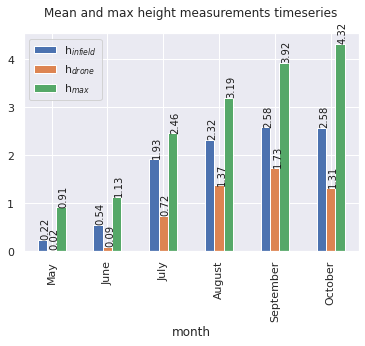

In [ ]:
level = {'May':0,'June':1,'July':2,'August':3,'September':4,'October':5}
monthly = hh.drop('yield', axis=1).groupby(['month']).mean()
monthly['month'] = monthly.index
monthly['index'] = monthly['month'].map(lambda x : level[x])
ax = monthly.sort_values('index').drop('index', axis =1).plot(kind ='bar')
                                                              
annotate_barplot(ax, size =10,hgap =0.04)
ax.legend(['h$_{infield}$','h$_{drone}$','h$_{max}$'])
ax.set_title('Mean and max height measurements timeseries', y=1.05)


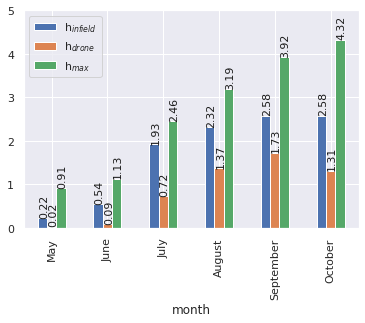

In [ ]:
monthly = hh.drop('yield',axis=1).groupby(['month']).mean()
monthly['month'] = monthly.index
monthly['index'] = monthly['month'].map(lambda x : level[x])
ax = monthly.sort_values('index').drop('index', axis =1).plot(kind ='bar', ylim=(0,5))
annotate_barplot(ax, size =11,hgap =0.02)
ax.legend(['h$_{infield}$','h$_{drone}$','h$_{max}$'])

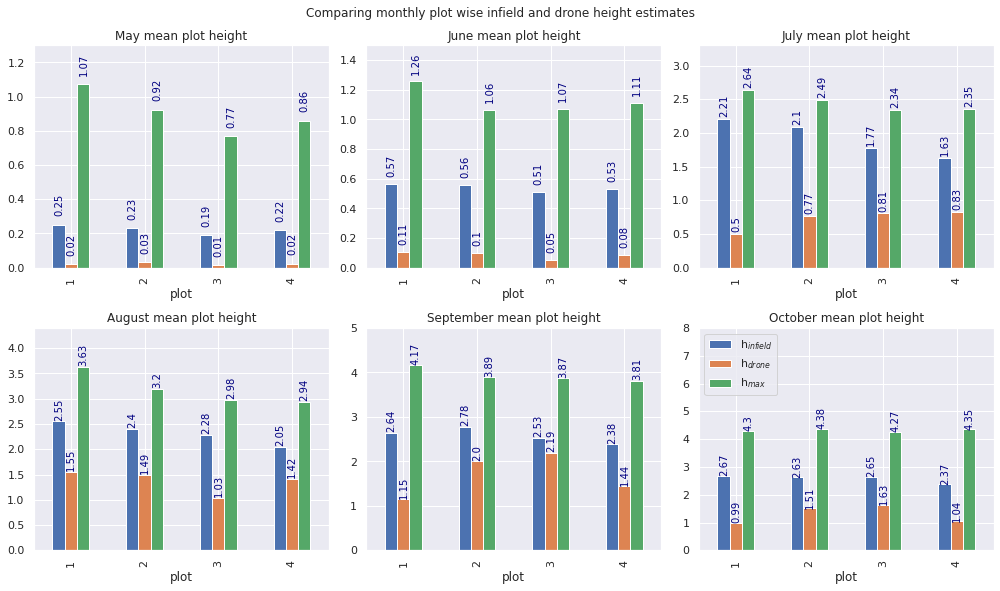

In [ ]:
fig,axs = plt.subplots(2,3, figsize=(14,8))
plt.suptitle('Comparing monthly plot wise infield and drone height estimates', y=1.02 )
axs = axs.ravel()
limits = [1.3,1.5,3.3,4.4,5,8]
for month,axes,ul in zip(hh['month'].unique(), axs,limits):
  pax = hh.drop('yield',axis=1).query('month =="{}"'.format(month)).groupby('plot').mean().plot(kind ='bar', 
                                                                                                ax = axes,legend=False,
                                                                                                ylim=(0,ul))
                                                                           
  
  axes.set_title(f'{month} mean plot height', y=1.0)
  annotate_barplot(pax, size =10, hgap=0.02, rot=90, color='navy', vgap=(0,00.06))
axes.legend(['h$_{infield}$','h$_{drone}$','h$_{max}$'],loc=2)
plt.tight_layout()


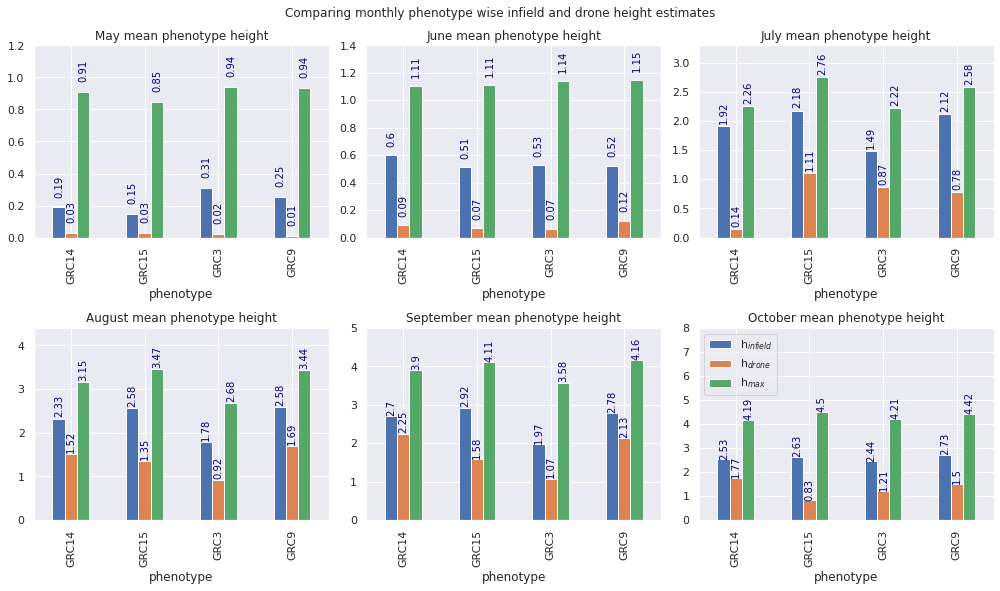

In [ ]:
fig,axs = plt.subplots(2,3, figsize=(14,8))
plt.suptitle('Comparing monthly phenotype wise infield and drone height estimates', y=1.02 )
limits =[1.2,1.4,3.3,4.4,5,8]
axs = axs.ravel()
for month,axes,ul in zip(hh['month'].unique(), axs,limits):
  pax = hh.drop('yield',axis=1).query('month =="{}"'.format(month)).groupby('phenotype').mean().plot(kind ='bar',
                                                                                                     ax = axes,legend=False,
                                                                                                     ylim=(0,ul))
                                                                           
  annotate_barplot(pax, size =10, hgap=0.02, rot=90, color='navy', vgap=(0,00.075))
  axes.set_title(f'{month} mean phenotype height', y=1.0)
axes.legend(['h$_{infield}$','h$_{drone}$','h$_{max}$'], loc=2)
plt.tight_layout()


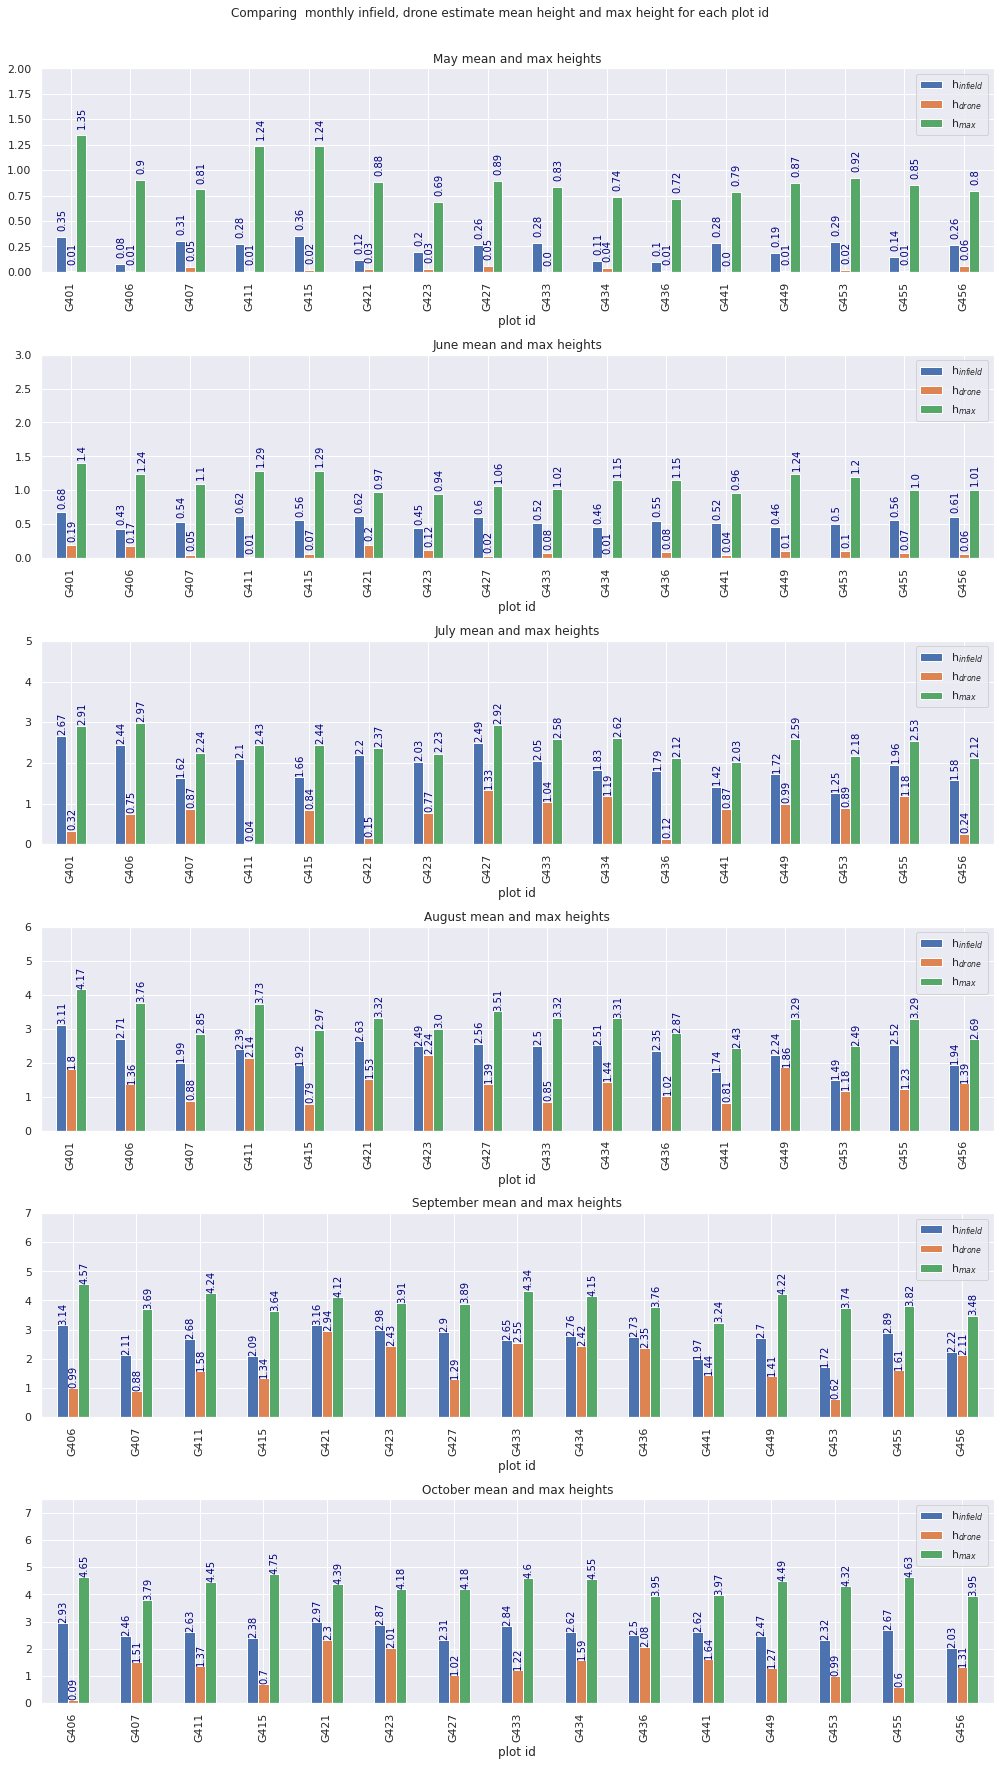

In [ ]:
fig,axs = plt.subplots(6,1, figsize=(14,24))
plt.suptitle('Comparing  monthly infield, drone estimate mean height and max height for each plot id', y=1.02 )
axs = axs.ravel()
limits =[2,3,5,6,7,7.5]
for month,axes,ul in zip(hh['month'].unique(), axs,limits):
  pax = hh.drop('yield',axis=1).query('month =="{}"'.format(month)).groupby('plot id').mean().plot(kind ='bar', ax = axes,
                                                                           title = f'{month} mean and max heights',ylim=(0,ul))
  annotate_barplot(pax, size =10, hgap=0.02, rot=90, color='navy', vgap=(0,00.08))
  axes.legend(['h$_{infield}$','h$_{drone}$','h$_{max}$'], loc=1)
plt.tight_layout()


Text(1.5, 4, 'R$^2$ = 0.66')

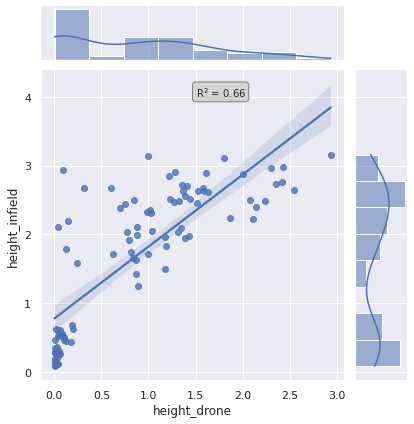

In [ ]:

x = hh['height_drone']
x = sm.add_constant(x)
y = hh['height_infield']
model = sm.OLS(y,x)
results = model.fit()
r2 = results.rsquared

g = sns.jointplot( data =hh, x='height_drone', y = 'height_infield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (1.5,4), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         height_infield   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     174.9
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           5.41e-23
Time:                        17:52:48   Log-Likelihood:                -83.863
No. Observations:                  94   AIC:                             171.7
Df Residuals:                      92   BIC:                             176.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7762      0.092      8.461      0.000       0.594       0.958
height_drone     1.0448      0.079     13.224      0.000       0.888       1.202
==============================================================================
Omnibus:                       16.130   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.316
Skew:                           1.017   Prob(JB):                     0.000105
Kurtosis:                       3.734   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(1.5, 3, 'R$^2$ = 0.90')

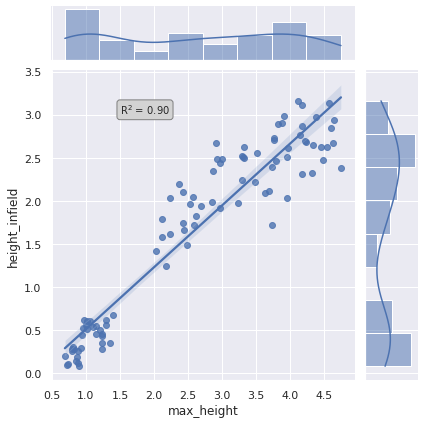

In [ ]:

x = hh['max_height']
x = sm.add_constant(x)
y = hh['height_infield']
model = sm.OLS(y,x)
results = model.fit()
r2 = results.rsquared

g = sns.jointplot( data =hh, x='max_height', y = 'height_infield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (1.5,3), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})


Text(1.5, 23, 'R$^2$ = 0.64')

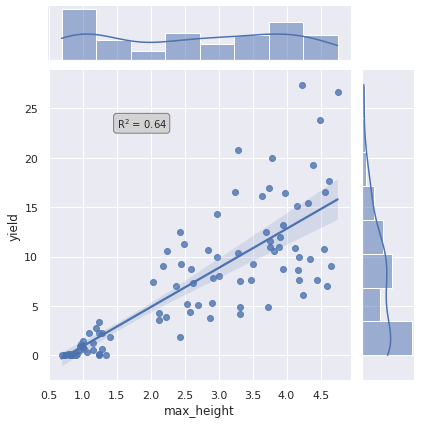

In [ ]:

x = hh['max_height']
x = sm.add_constant(x)
y = hh['yield']
model = sm.OLS(y,x)
results = model.fit()
r2 = results.rsquared

g = sns.jointplot( data =hh, x='max_height', y = 'yield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (1.5,23), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})


Text(1.5, 3, 'R$^2$ = 0.52')

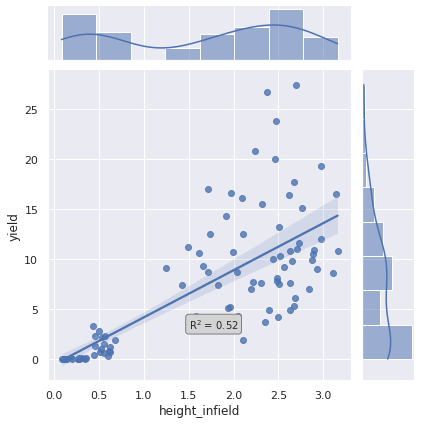

In [ ]:

x = hh['height_infield']
x = sm.add_constant(x)
y = hh['yield']
model = sm.OLS(y,x)
results = model.fit()
r2 = results.rsquared

g = sns.jointplot( data =hh, x='height_infield', y = 'yield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (1.5,3), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})


In [ ]:
hh.head()

,month,plot id,phenotype,height_infield,date_infield,plot,height_drone,date_drone,max_height,yield
0,May,G401,GRC9,0.346,2020-05-05,1,0.008559,2020-05-08,1.350037,0.055
1,May,G406,GRC15,0.082,2020-05-05,1,0.006110,2020-05-08,0.899963,0.005
2,May,G411,GRC14,0.276,2020-05-05,1,0.012622,2020-05-08,1.239990,0.015
3,May,G415,GRC3,0.356,2020-05-05,2,0.023479,2020-05-08,1.239990,0.095
4,May,G421,GRC14,0.118,2020-05-05,2,0.027550,2020-05-08,0.880005,0.030


In [ ]:
hhgrouped = hh.groupby(['phenotype','date_drone'])[['height_infield', 'height_drone','max_height']].mean()

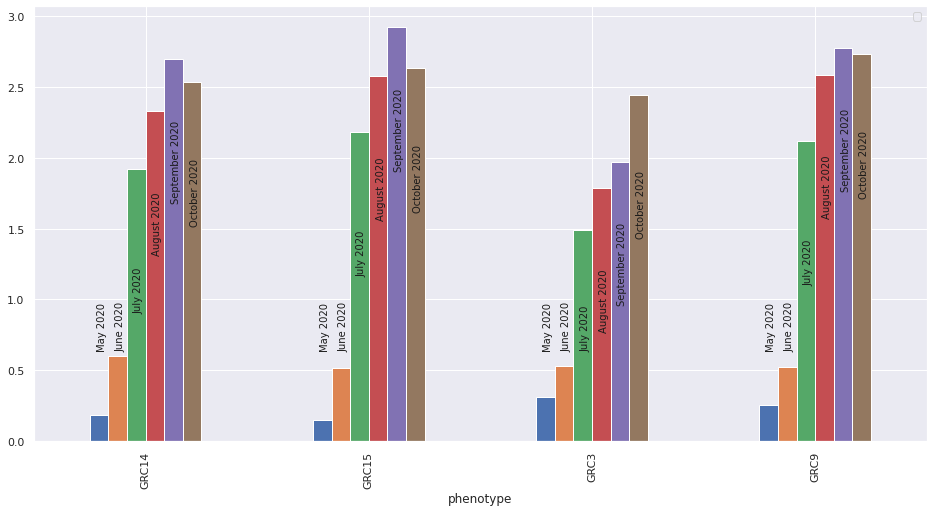

In [ ]:
ax = hhgrouped['height_infield'].unstack(level=1).plot(kind ='bar', figsize=(16,8))
annotate_barplot_with_legend(ax, hgap=0.03, vgap=(0.65,-1), dates=True)

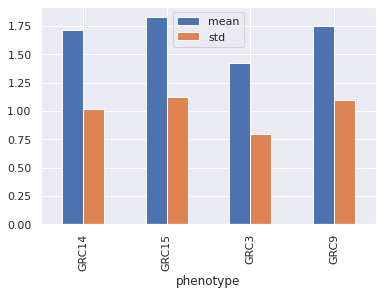

In [ ]:
hh.groupby(['phenotype'])['height_infield'].agg([np.mean,np.std]).plot(kind ='bar')

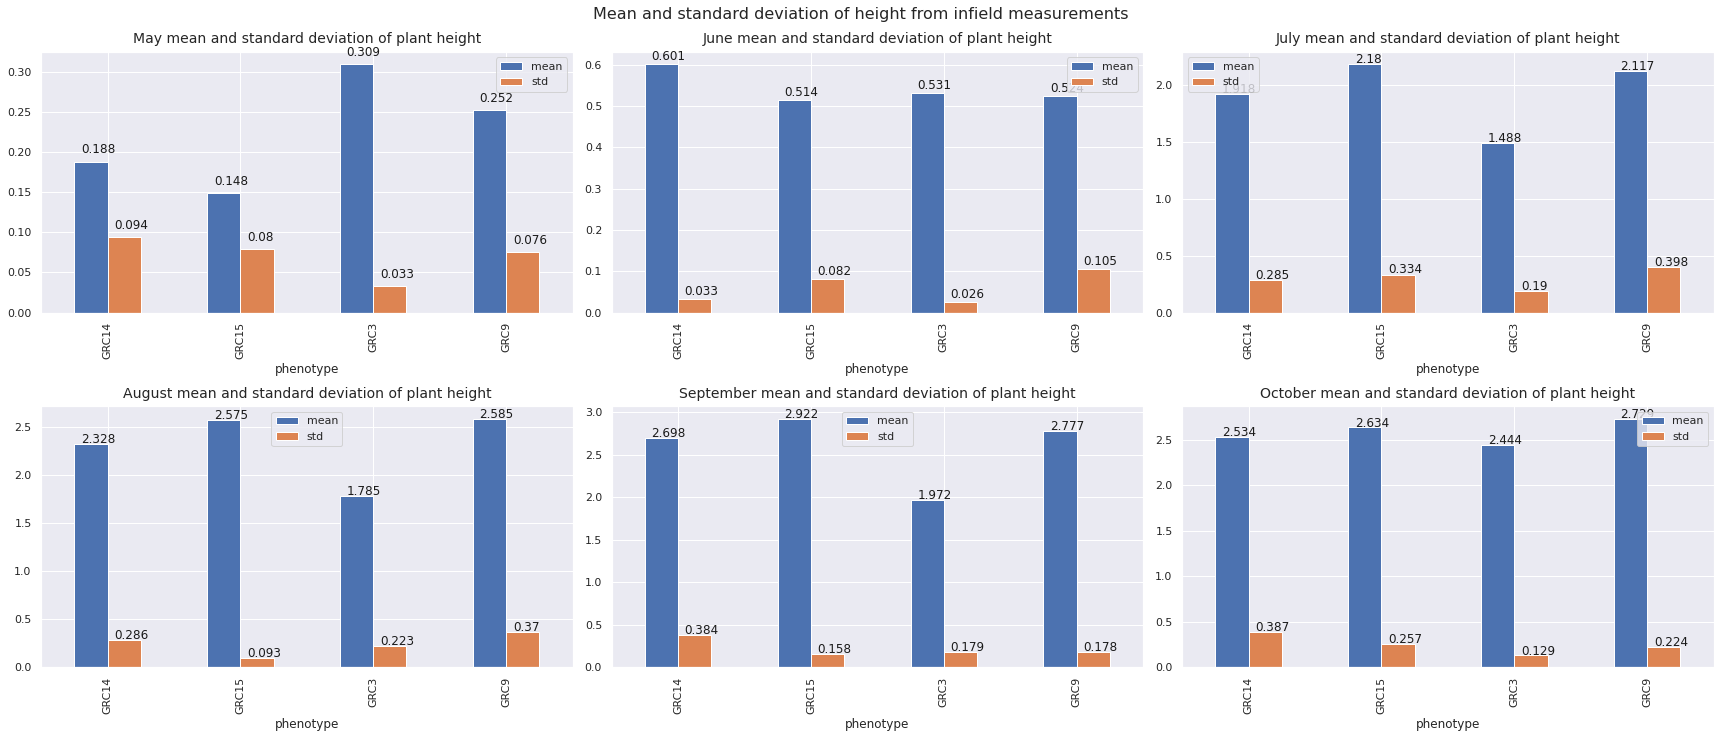

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(24,10))
fig.suptitle(f'Mean and standard deviation of height from infield measurements', y=1.02, fontsize=16)
axes=axes.ravel()

months = ['May','June','July','August','September','October']
'''bars = hh.groupby('phenotype')['height_infield'].agg([np.mean,np.std]).sort_values('mean').plot(kind='bar', ax=axes[0],
                                                                                                title = f' mean and standard deviation of plant height measured infield', color=['gray','cadetblue'])
annotate_barplot(bars,vgap=(0.01,0.025),hgap=0, rot= 0,size=10)'''

for ax,month in zip(axes,months):  
  bars = hh.where(hh['month']==month).groupby('phenotype')['height_infield'].agg([np.mean,np.std]).plot(kind='bar', ax=ax)
                                                                                                        
  ax.set_title(f'{month.capitalize()} mean and standard deviation of plant height',y=1.01, fontsize=14)
  annotate_barplot(bars,vgap=(0.015,0.01),hgap=0.05, rot= 0, size=12,round=3)
 
plt.tight_layout()

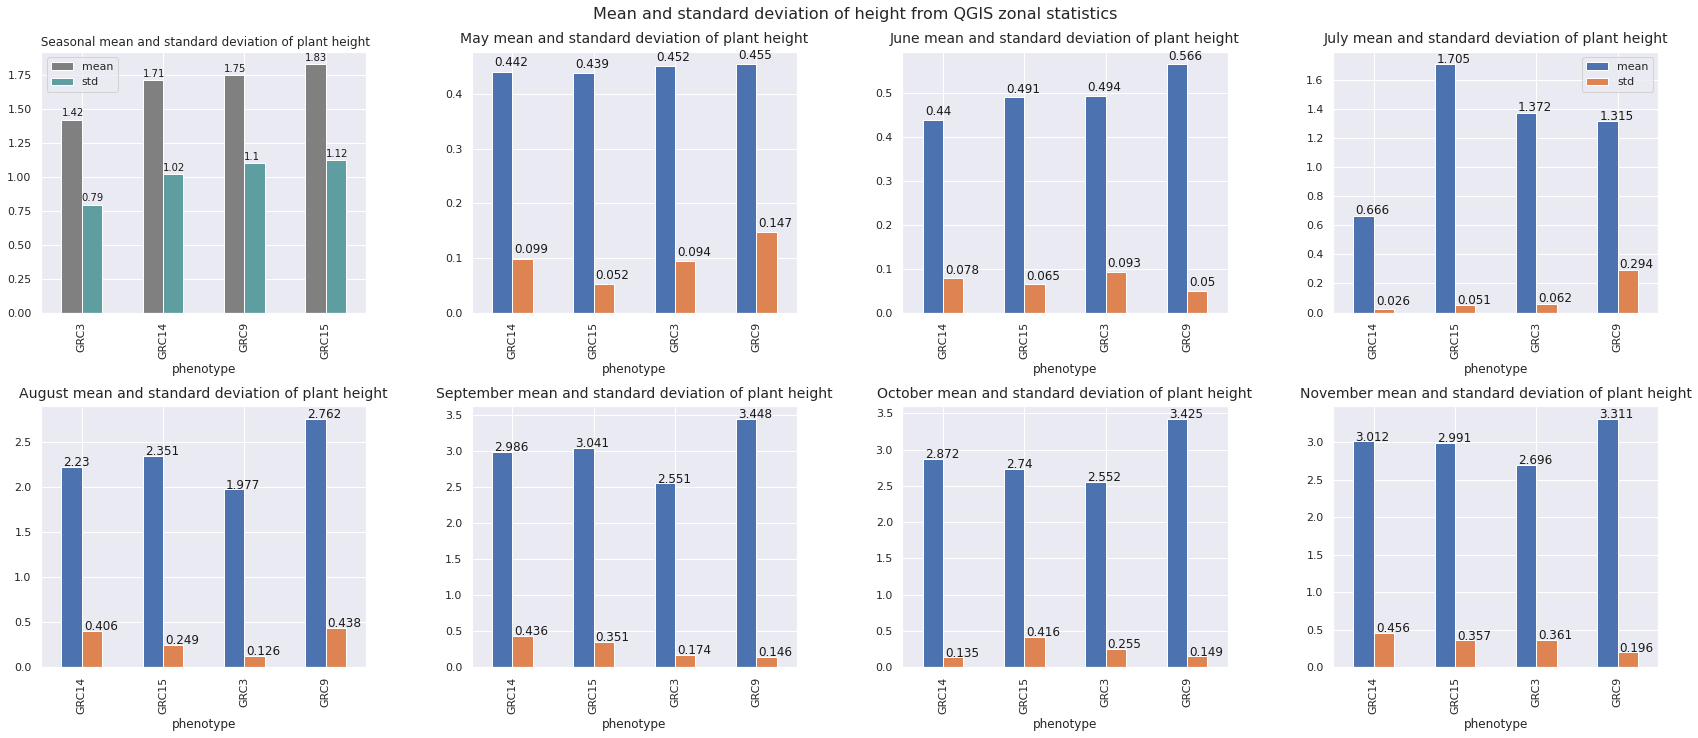

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(24,10))
fig.suptitle(f'Mean and standard deviation of height from QGIS zonal statistics', y=1.02, fontsize=16)
axes=axes.ravel()

months = ['May','June','July','August','September','October','November']
bars = hh.groupby('phenotype')['height_infield'].agg([np.mean,np.std]).sort_values('mean').plot(kind='bar', ax=axes[0],
                                                                                                title = f' Seasonal mean and standard deviation of plant height', color=['gray','cadetblue'])
annotate_barplot(bars,vgap=(0.01,0.025),hgap=0, rot= 0,size=10)

for ax,month in zip(axes[1:],months):  
  bars = merged.where(merged['month']==month).groupby('phenotype')['height_zc'].agg([np.mean,np.std]).plot(kind='bar', ax=ax,legend=(month=='July'))
                                                                                                        
  ax.set_title(f'{month.capitalize()} mean and standard deviation of plant height',y=1.01, fontsize=14)
  annotate_barplot(bars,vgap=(0.05,0.01),hgap=0.025, rot= 0, size=12,round=3)

plt.tight_layout()

In [ ]:
merged.head()

,month,plot,phenotype,_count,_stdev,max_height,height,height_zc,area,area_zc,volume,volume_zc,yield,varimean,ngrdimean
0,August,1,GRC9,202206.0,0.661836,4.169983,1.803391,3.411,112.837396,112.928,203.49,385.197,8.590,0.442024,0.304643
1,August,1,GRC15,210884.0,0.789561,3.760010,1.360650,2.457,117.679093,117.774,160.12,289.371,10.945,0.422120,0.270953
2,August,1,GRC3,211281.0,0.362938,2.849976,0.879368,2.107,117.880167,117.975,103.66,248.573,10.700,0.433715,0.314817
3,August,1,GRC14,166887.0,0.667292,3.730042,2.141965,2.643,93.134094,93.209,199.49,246.351,4.940,0.387355,0.285468
4,August,2,GRC3,209278.0,0.443558,2.969971,0.793797,2.061,116.793124,116.887,92.71,240.904,14.305,0.429837,0.316568


In [ ]:
hc = pd.merge(merged[['month','phenotype','plot','height_zc','height']],hh[['month','phenotype','plot','height_infield','yield']], 
         on=['month','phenotype','plot'])
hc.shape

(94, 7)

In [ ]:
hc.rename({'height':'height_wodm'}, axis='columns',inplace=True)
hc.head()

,month,phenotype,plot,height_zc,height_wodm,height_infield,yield
0,August,GRC9,1,3.411,1.803391,3.11,8.590
1,August,GRC15,1,2.457,1.360650,2.71,10.945
2,August,GRC3,1,2.107,0.879368,1.99,10.700
3,August,GRC14,1,2.643,2.141965,2.39,4.940
4,August,GRC3,2,2.061,0.793797,1.92,14.305


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(1.5, 3, 'R$^2$ = 0.66')

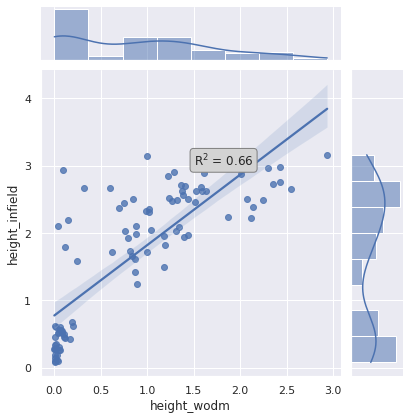

In [ ]:

x = hh['height_wodm']
x = sm.add_constant(x)
y = hh['height_infield']
model = sm.OLS(y,x)
results = model.fit()
r2 = results.rsquared

g = sns.jointplot( data =hh, x='height_wodm', y = 'height_infield', ci=95, kind ='reg')
g.ax_joint.annotate(f'R$^2$ = {r2:.2f}', (1.5,3), bbox={'boxstyle': 'round', 'fc': 'lightgray', 'ec': 'gray'})


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(1.5, 3, 'R$^2$ = 0.81')

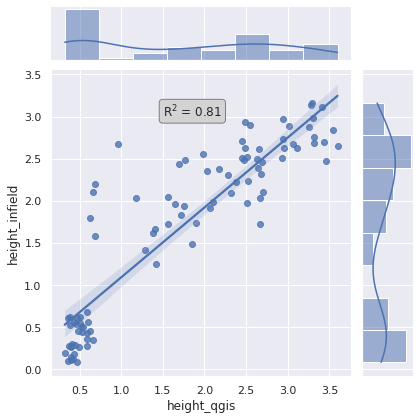

In [ ]:
encoded.head()

,month,plot,phenotype,_count,_stdev,max_height,height,height_zc,area,area_zc,volume,volume_zc,yield,vari,ngrdi,GRC14,GRC15,GRC3,GRC9,plot_1,plot_2,plot_3,plot_4
0,August,1,GRC9,202206.0,0.661836,4.169983,1.803391,3.411,112.837396,112.928,203.49,385.197,8.590,0.442024,0.304643,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,August,1,GRC15,210884.0,0.789561,3.760010,1.360650,2.457,117.679093,117.774,160.12,289.371,10.945,0.422120,0.270953,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,August,1,GRC3,211281.0,0.362938,2.849976,0.879368,2.107,117.880167,117.975,103.66,248.573,10.700,0.433715,0.314817,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,August,1,GRC14,166887.0,0.667292,3.730042,2.141965,2.643,93.134094,93.209,199.49,246.351,4.940,0.387355,0.285468,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,August,2,GRC3,209278.0,0.443558,2.969971,0.793797,2.061,116.793124,116.887,92.71,240.904,14.305,0.429837,0.316568,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
poly      = PolynomialFeatures(degree = 2)
X_poly    = poly.fit_transform(encoded[['max_height']])

y         = encoded['yield']

X_train,X_test, y_train,y_test = train_test_split(X_poly,y)

scaler = MinMaxScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled   = scaler.transform(X_test)

# model fitting 
clf             = LinearRegression()
clf.fit(X_train_scaled, y_train)


LinearRegression()

In [ ]:
predicted_yield = clf.predict(X_test_scaled)
pred = pd.Series(predicted_yield)

#y_test = y_test.reset_index().drop('index', axis=1)

In [ ]:
g = sns.scatterplot(x=pred, y=y_test)
g.set_xlabel('predicted yield')
g.set_title('scatter plot predicted yield vs actual yield')

ValueError: ignored

In [ ]:
pred.head()


0    0.078027
1    1.802041
2    9.690050
3    6.935812
4    0.375679
dtype: float64

In [ ]:
y_test.shape

(28, 1)

In [ ]:

pred.shape

(28,)

In [ ]:
pd.Series(y_test).reset_index().drop('index', axis=1)

(28, 1)